In [30]:
import os
import re
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# from oneibl.onelight import ONE # only used for downloading data
# import wget
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')
colorsFeatures = [['#FAA61A','indigo','#99CC66','#59C3C3','#9593D9'],['#FAA61A',"#2369BD","#A9373B",'#99CC66','#59C3C3','#9593D9']]
#colorsStates = ['orange','firebrick','forestgreen']#['orange','slateblue','forestgreen'] #['#FAA61A','#59C3C3','#9593D9','#99CC66','indigo'] #['darkorange','darkblue','forestgreen','purple']
colorsStates = ['tab:orange','tab:blue', 'tab:green','tab:red']
myFeatures = [['bias','delta stimulus', 'previous choice', 'previous answer'],['bias','contrast left','contrast right', 'previous choice', 'previous answer']]
sns.set_context("talk")
# colormap = ['rebeccapurple','teal','darkturquoise','springgreen','gold']
# colormap = ['rebeccapurple','royalblue','limegreen','orange']
colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen']

In [31]:
labChosen =  ['angelakilab','churchlandlab','wittenlab']
subjectsAll = []
for lab in labChosen:
    subjects = np.unique(dfAll[dfAll['lab'] == lab]['subject']).tolist()
    subjectsAll = subjectsAll + subjects

if ('NYU-01' in subjectsAll):
    subjectsAll.remove('NYU-01')
if ('NYU-06' in subjectsAll):
    subjectsAll.remove('NYU-06')
if ('CSHL_007' in subjectsAll):
    subjectsAll.remove('CSHL_007')
if ('CSHL049' in subjectsAll):
    subjectsAll.remove('CSHL049')


In [32]:
# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
alphaList = [2*(10**x) for x in list(np.arange(-1,6,0.5,dtype=float))] 
L2penaltyW = 1
maxiter = 200
bestSigma = 1 # verified from fitting multiple sigmas
bestSigmaInd = 7
bestAlpha = 2
priorDirP = [100,10] # to read dGLMHMM1 model
fit_init_states = False
K = 3
D = 4 # number of features
sessStop = -1 # last session to use in fitting
splitFolds = 5
inits = 21

In [33]:
# NEW SAVING OF FILES AND MORE ANIMALS:
testLlAll = np.zeros((4, len(subjectsAll), len(sigmaList)))
testAccuracyAll = np.zeros((4, len(subjectsAll), len(sigmaList)))
bestTestLl = np.zeros((4, len(subjectsAll)))
bestTestAccuracy = np.zeros((4, len(subjectsAll)))

for idx in range(0, len(subjectsAll)):
    subject = subjectsAll[idx]
    testLl = []
    testAccuracy = []
    avgTestLl = []
    avgTestAccuracy = []
    for K in [1,2,3,4]:
        data = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_{K}-state_multiple-sigmas_priorDirP={priorDirP}_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz')
        # fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
        # fig.suptitle(f'{subject}')
        # for fold in range(0, splitFolds):
        #     plot_testLl_CV_sigma(data['testLl'][fold], sigmaList=sigmaList, label=f'K={K} fold {fold}', color=colormap[K-1], axes=axes)
        avgTestLl.append(np.mean(data['testLl'],axis=0))
        avgTestAccuracy.append(np.mean(data['testAccuracy'],axis=0))
    avgTestLl = [x - avgTestLl[0][0] for x in avgTestLl] # normalizing to GLM-HMM sigma=0 K=1
    avgTestAccuracy = [x - avgTestAccuracy[0][0] for x in avgTestAccuracy]
    
    for K in [1,2,3,4]:
        testLlAll[K-1][idx] = avgTestLl[K-1]
        testAccuracyAll[K-1][idx] = avgTestAccuracy[K-1]

    bestSigmaInd = 7 # Choosing best sigma index across animals
    for K in [1,2,3,4]:
        bestTestLl[K-1][idx] = avgTestLl[K-1][bestSigmaInd] - avgTestLl[0][bestSigmaInd] # delta
        bestTestAccuracy[K-1][idx] = avgTestAccuracy[K-1][bestSigmaInd] - avgTestAccuracy[0][bestSigmaInd] # delta
    
    # # Plotting delta test ll averaged across folds for per-animal plots
    # fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
    # fig.suptitle(f'{subject}')
    # fig.tight_layout()
    # for K in range(1,5):
    #     plot_testLl_CV_sigma(avgTestLl[K-1], sigmaList=sigmaList, label=f'K={K}', color=colormap[K-1], axes=axes)
    # axes.set_ylabel("Delta Test Ll (per trial)")

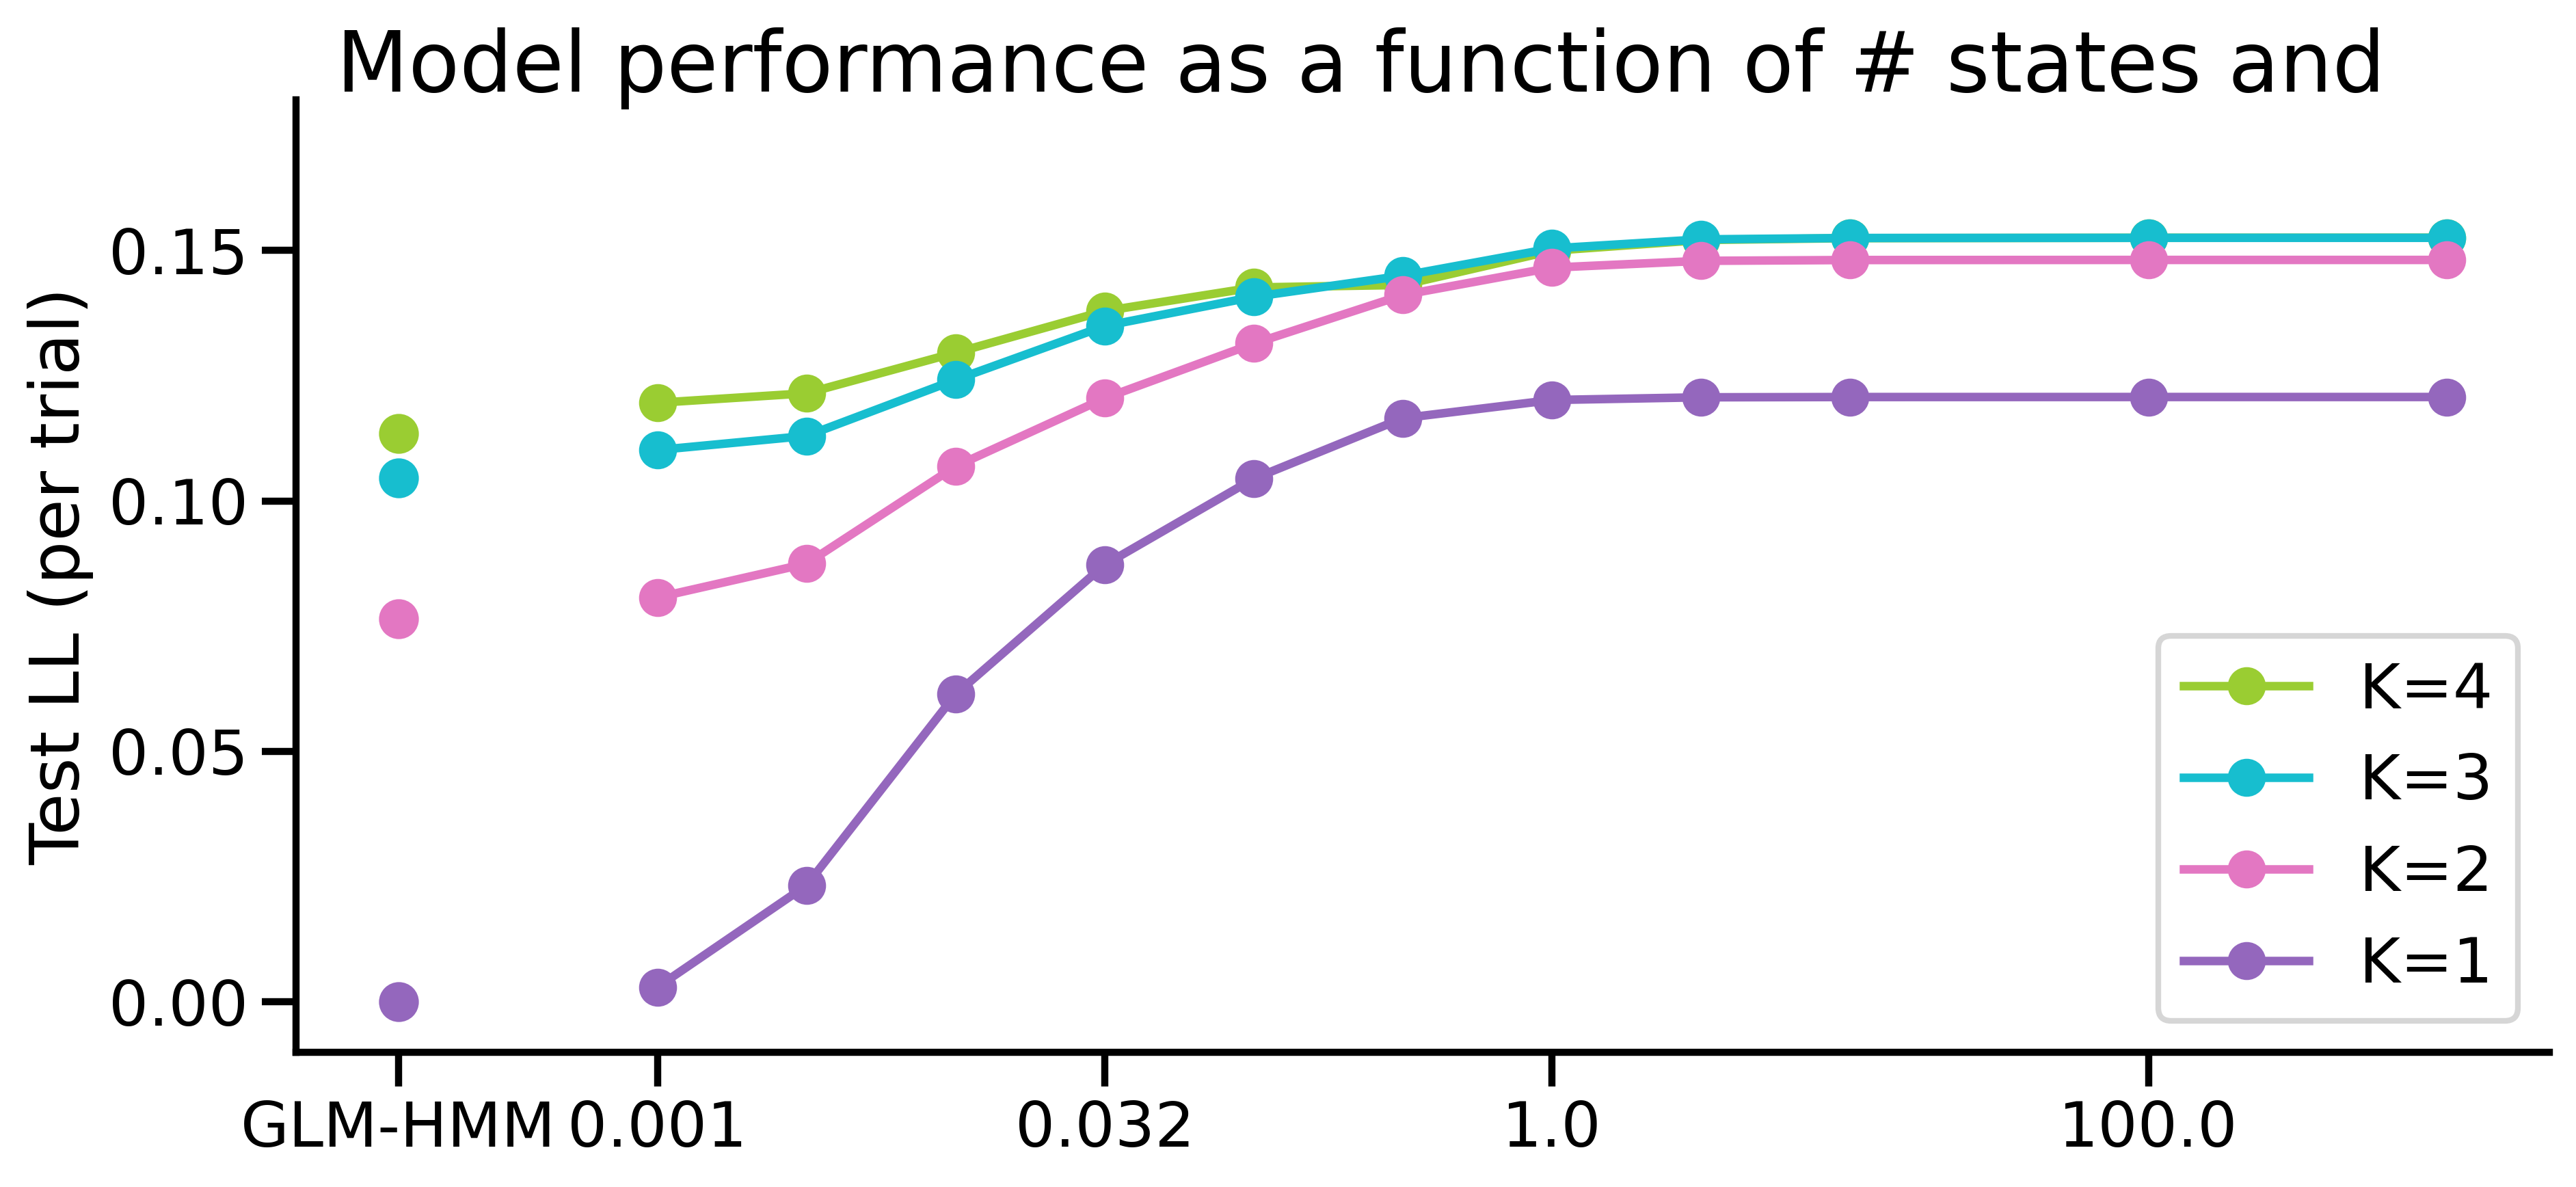

In [35]:
# Plotting one plot with all animals and their mean
fig, axes = plt.subplots(1, figsize = (9.5,4.5), dpi=400)
# fig, axes = plt.subplots(1, figsize = (12,5.5), dpi=400)
fig.tight_layout()
# axes.set_title('averaged across all animals')
for K in range(4,0,-1):
    for idx in range(0, len(subjectsAll)):
        subject = subjectsAll[idx]
        # plot_testLl_CV_sigma(testLlAll[K-1][idx], sigmaList=sigmaList, label=None, color=colormap[K-1], axes=axes, alpha=0.06)

    plot_testLl_CV_sigma(np.mean(testLlAll[K-1], axis=0), sigmaList=sigmaList, label=f'K={K}', color=colormap[K-1], axes=axes, alpha=1)
axes.set_ylabel('Test LL (per trial)')
axes.set_xlabel('')
axes.set_ylim(-0.01,0.18)
axes.spines[['right', 'top']].set_visible(False)
fig.suptitle('Model performance as a function of # states and ', size=22)
plt.savefig(f'../figures/TestLl_vs_states_sigma_all-animals.png', bbox_inches='tight', dpi=400)

(-0.001, 0.05)

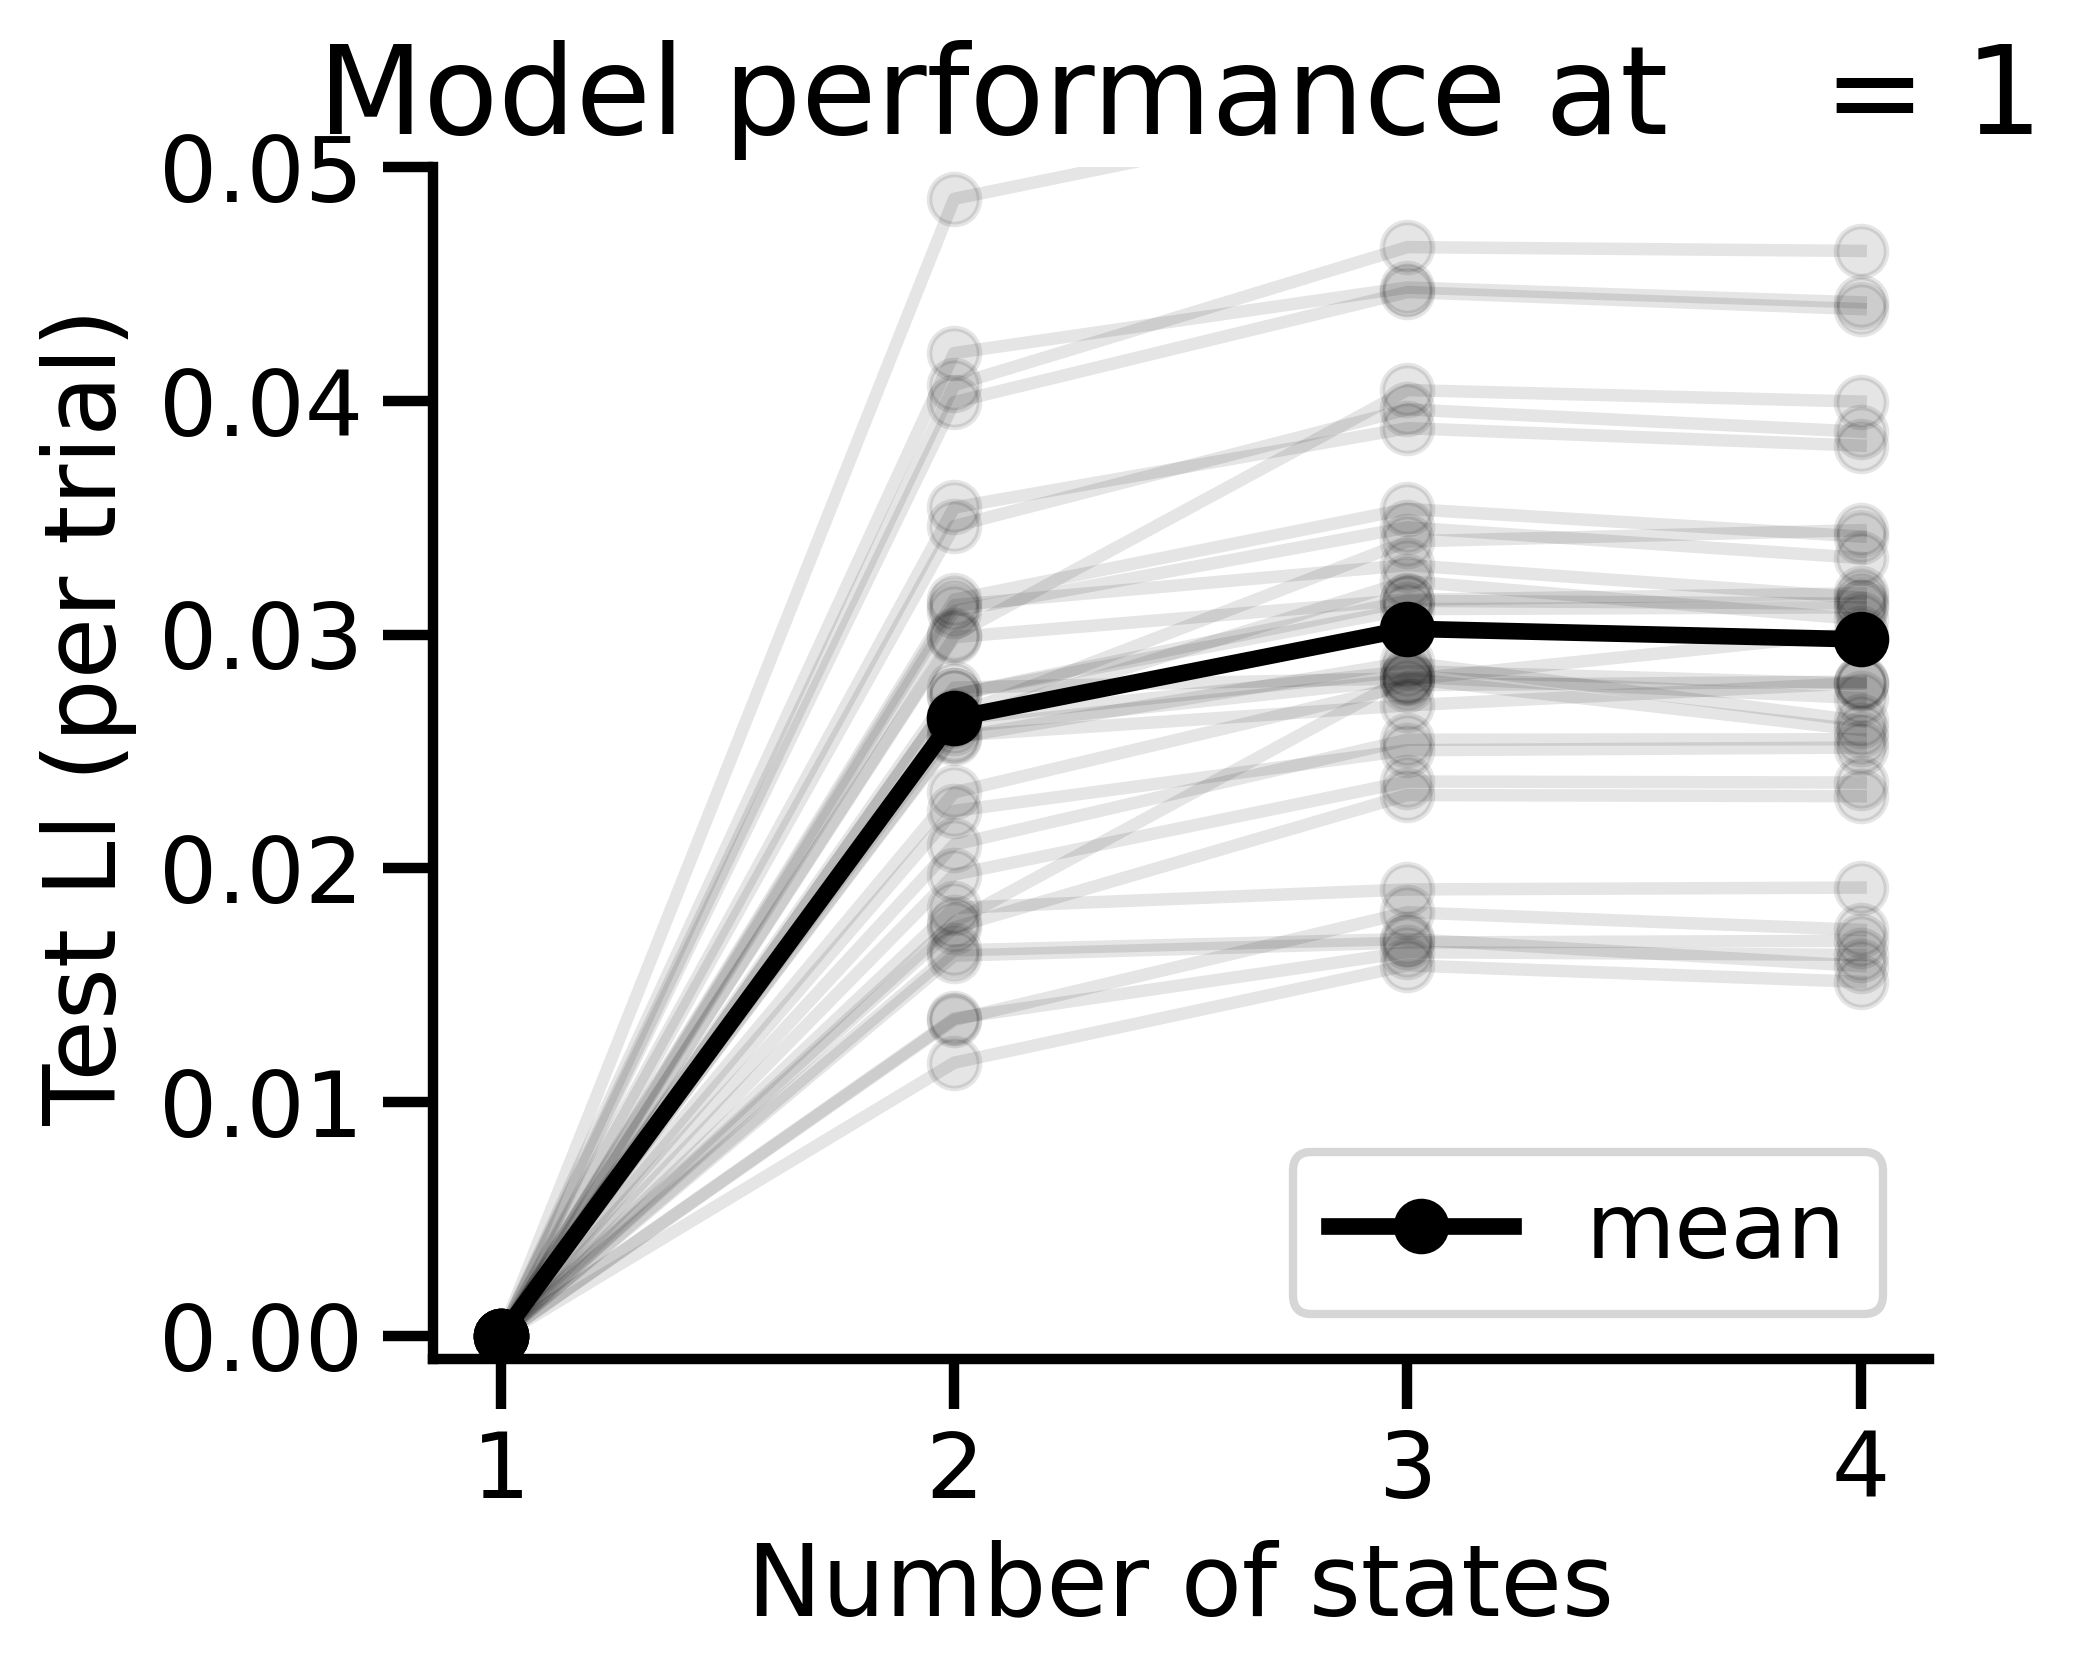

In [8]:
fig, axes = plt.subplots(1,figsize=(5,4), dpi=400)
# fig, axes = plt.subplots(1,figsize=(6,5.5), dpi=400)
fig.tight_layout()
for idx in range(0, len(subjectsAll)):
    axes.plot([1,2,3,4],bestTestLl[:,idx],'-o', color='black',alpha=0.1)
    axes.set_xticks([1,2,3,4])
# plotting mean across all animals
axes.plot([1,2,3,4], np.mean(bestTestLl, axis=1), '-o', color='black',alpha=1, label='mean', linewidth=3)
axes.set_title(f'sigma={np.round(sigmaList[bestSigmaInd],2)}')
axes.set_xlabel('Number of states')
axes.set_ylabel('   Test Ll (per trial)')
axes.spines[['right', 'top']].set_visible(False)
axes.set_title('Model performance at    = 1', size=22)
axes.legend(loc='lower right')
axes.set_ylim(-0.001,0.05)
# plt.savefig(f'../figures/TestLl_vs_states_sigma=1_all-animals.png', bbox_inches='tight', dpi=400)

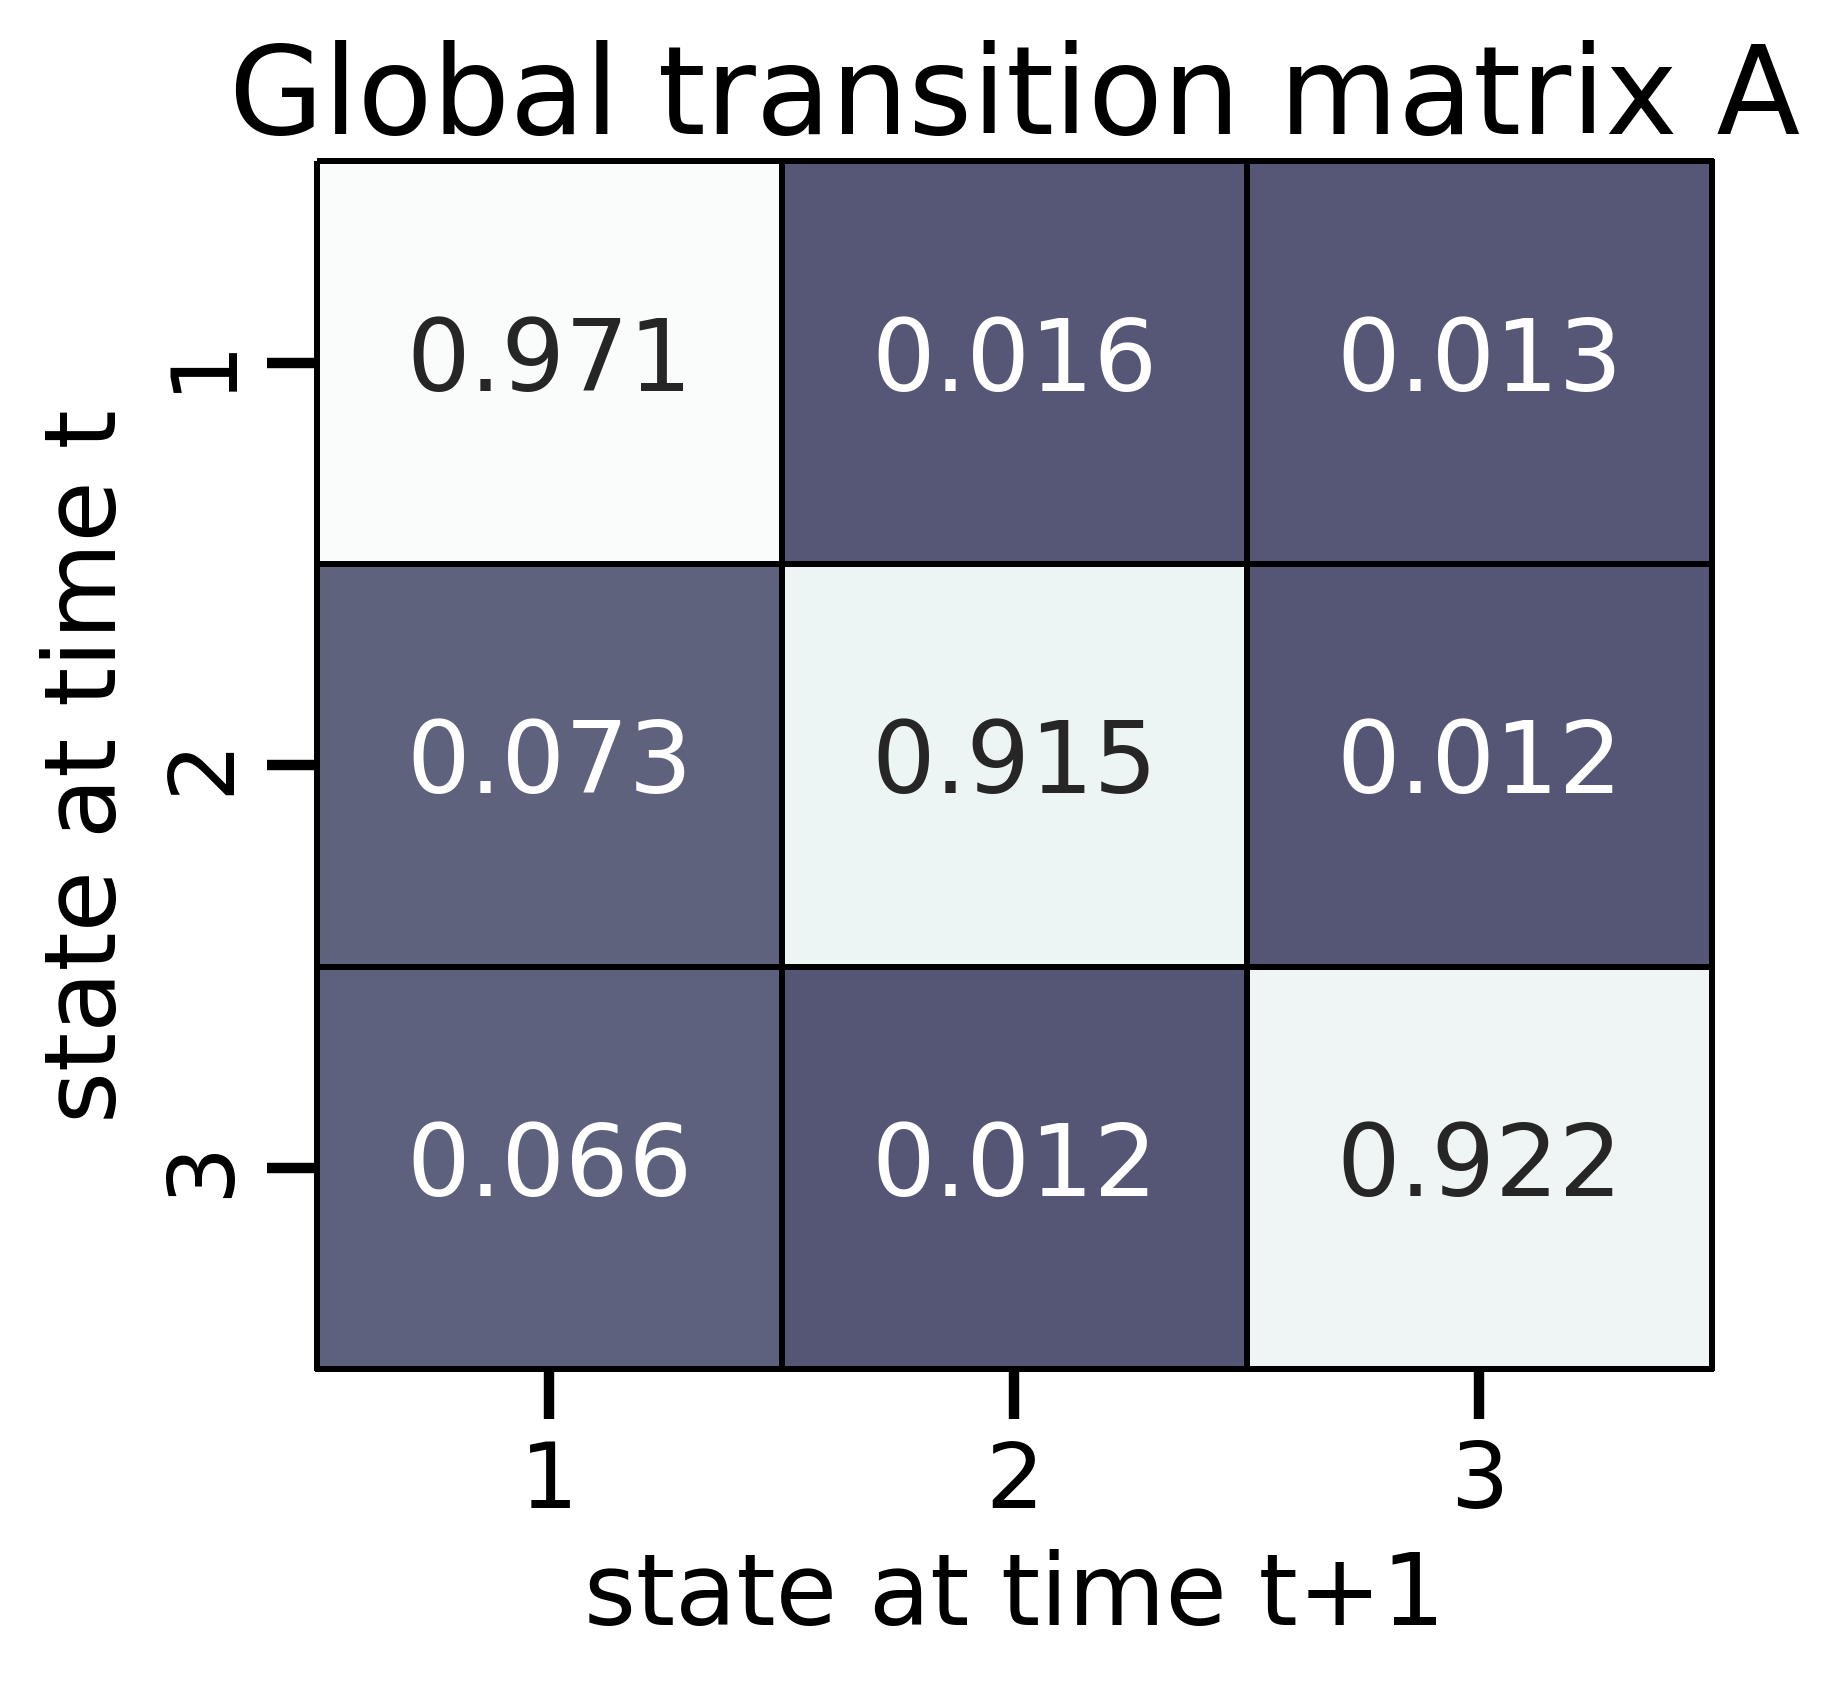

In [176]:
# Reading parameters and plotting them at best sigma for 
bestSigmaInd = 7 # equivalent to sigma=1
K = 3

allP = np.zeros((len(subjectsAll), K, K))   

for idx in range(0, len(subjectsAll)):
    subject=subjectsAll[idx]
    _, _, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)
    data = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_{K}-state_multiple-sigmas_priorDirP={priorDirP}_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz')
    allP[idx] = np.mean(data['allP'], axis=0)[bestSigmaInd]

plt.figure(figsize=(4.5, 4), dpi=400)
K = np.mean(allP, axis=0).shape[0] # 
s = sns.heatmap(np.round(np.mean(allP, axis=0),3),annot=True, vmin=-0.6, vmax=1,cmap='bone', fmt='g', linewidths=1, linecolor='black',clip_on=False, cbar=False)
s.set(xlabel='state at time t+1', ylabel='state at time t', title=f'', xticklabels=range(1,K+1), yticklabels=range(1,K+1))
plt.title('Global transition matrix A', size=22, pad=5)
plt.savefig(f'../figures/AverageP_2-state_sigma=1_allAnimals.png', bbox_inches='tight', dpi=400)

In [10]:
allW0 = np.empty((len(subjectsAll)), dtype=object)
for idx in range(0, len(subjectsAll)):
    subject=subjectsAll[idx]
    _, _, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)

    data = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_{K}-state_multiple-sigmas_priorDirP={priorDirP}_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz')
    allW0[idx] = np.mean(data['allW'], axis=0)[0] # standard GLM-HMM

In [16]:
# INIT 0 means initialized from global fit
allW = np.empty((len(subjectsAll)), dtype=object)
allP = np.empty((len(subjectsAll)), dtype=object)

for idx in range(0,len(subjectsAll)):
    subject=subjectsAll[idx]
    _, _, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)
    param = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_{K}_state_alpha={bestAlpha}_multiple-initsP_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz')
    allP[idx] =  param['allP'][0] # starting from best dGLMHMM1 fit
    allW[idx] =  param['allW'][0] # starting from best dGLMHMM1 fit
    

In [12]:
allPhi = np.empty((len(subjectsAll)), dtype=object) # observation probabilities
for idx in range(0,len(subjectsAll)):
    subject=subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)
    N = sessInd[-1]
    dGLMHMM2 = dglm_hmm2.dGLM_HMM2(N,K,D,2)
    allPhi[idx] = dGLMHMM2.observation_probability(x, allW[idx])

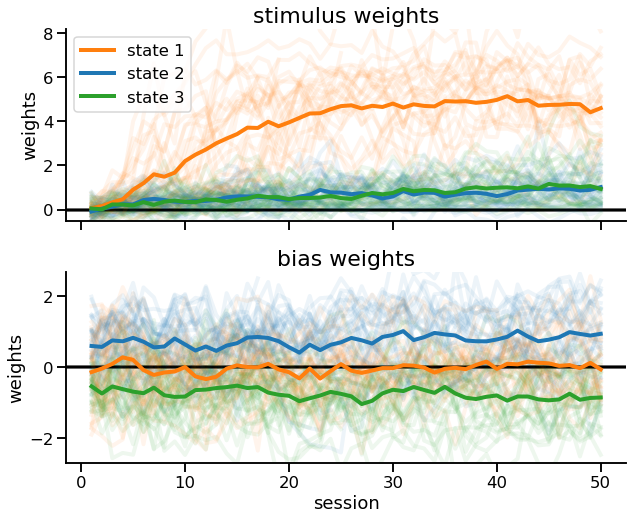

In [22]:
# Plotting weights and transition matrix averaged across all animals - first 70 sessions
maxSess = 51
Kplot = [3]
bestSigmaInd = 7
reorderFeatures = [1,0,2,3] 
myFeatures = ['stimulus','bias','previous choice','previous correct side']
for K in Kplot:
    arrW = np.ma.empty((maxSess, K, D, 2, len(subjectsAll)))
    arrW.mask = True

    #fig, axes = plt.subplots(D, 1,figsize=(12.5,15), sharex=True)#, dpi=400)
    fig, axes = plt.subplots(D-2, 1,figsize=(9.5,7.5), sharex=True)
    fig.tight_layout(pad=2)
    yLim=[[-0.5,8.2],[-2.7,2.7],[-2.7,2.7],[-2.7,2.7]]

    avgP = []
    avgW = []
    for idx in range(0,len(subjectsAll)):
        subject = subjectsAll[idx] 
        _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)

        avgW.append(allW[idx][sessInd[:-1]]) 
        avgP.append(allP[idx][sessInd[:-1]])
        stop = min(avgW[idx].shape[0], maxSess)
        arrW[:stop, :K, :D, :2, idx] = avgW[idx][:stop]
        plotting_weights_per_feature(-(avgW[idx][:stop,:,reorderFeatures[:-2]]), [x for x in range (0, stop)], axes, yLim=yLim, colors=colorsStates, labels=['stimulus','bias','previous choice','previous correct answer'], linewidth=4, linestyle='-', alpha=0.08, legend=False, sortedStateInd=None)
    # plotting_weights_per_feature(-(allW0[0][:,:,reorderFeatures]), [x for x in range (0, maxSess)], axes, yLim=yLim, colors=colorsStates, labels=['stimulus','bias','previous choice','previous correct answer'], linewidth=3, linestyle='--', alpha=1, legend=False, sortedStateInd=None)
    plotting_weights_per_feature(-(arrW.mean(axis=4)[:,:,reorderFeatures[:-2]]), [x for x in range (0, maxSess)], axes, yLim=yLim, colors=colorsStates, labels=['stimulus','bias','previous choice','previous correct answer'], linewidth=4, linestyle='-', alpha=1, legend=True, sortedStateInd=None)
    

for d in range(0,D-2):
    if (d!=0):
        axes[d].get_legend().remove()
    axes[0].legend(loc = 'upper left')
    axes[d].set_ylim(yLim[d])
    axes[d].set_ylabel(f'weights')
    axes[d].set_title(f'{myFeatures[d]} weights', size=22)
    axes[d].spines[['right', 'top']].set_visible(False)

plt.savefig(f'../figures/weights_sigma=1_allAnimals.png', bbox_inches='tight', dpi=400)

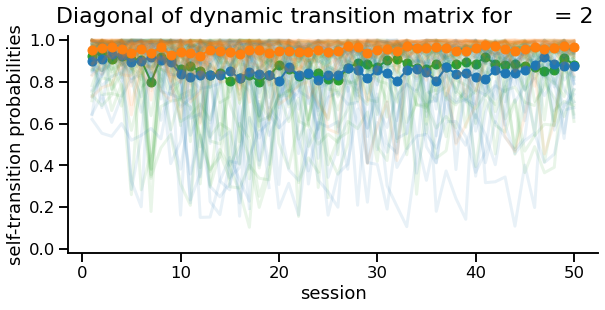

In [24]:
# Plotting weights and transition matrix averaged across all animals - first 70 sessions
maxSess = 51
Kplot = [3]
bestSigmaInd = 7
reorderFeatures = [1,0,2,3] 
#fig, axes = plt.subplots(1, figsize = (12.5,5))
fig, axes = plt.subplots(1, figsize = (9.5,4))
for K in Kplot:
    arrP = np.ma.empty((maxSess, K, K, len(subjectsAll)))
    arrP.mask = True

    avgP = []
    for idx in range(0,len(subjectsAll)):
        subject = subjectsAll[idx] 
        _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)

        avgP.append(allP[idx][sessInd[:-1]])
        stop = min(avgW[idx].shape[0], maxSess)
        arrP[:stop, :K, :K, idx] = avgP[idx][:stop]
        sessInd = range(0,stop)
        sess = len(sessInd)-1
        for i in range(0,avgP[idx][:stop].shape[1]):
            axes.plot(range(1,sess+1), avgP[idx][:stop][sessInd[:-1],i,i], linestyle='-', linewidth=3, color=colorsStates[i], label=f'state {i+1}', zorder=avgP[idx][:stop].shape[1]-i, alpha=0.1)
        
        # plotting_self_transition_probabilities(avgP[idx][:stop], range(0,stop), axes, title='', linestyle='-', linewidth=2, save_fig=False, sortedStateInd=None, colorsStates=colorsStates)
    
    plotting_self_transition_probabilities(arrP.mean(axis=3), range(0,maxSess), axes, title='', linewidth=2, save_fig=False, sortedStateInd=None, colorsStates=colorsStates)
    # # plotting transition matrix averaged across folds
    # fig, axes = plt.subplots()
    # plot_transition_matrix(np.mean(avgP, axis=0), title='Averaged', sortedStateInd=None) # not sorted

axes.set_ylabel("self-transition probabilities")
axes.set_xlabel('session')
axes.spines[['right', 'top']].set_visible(False)
fig.suptitle('Diagonal of dynamic transition matrix for      = 2', size=22)
axes.set_ylim(-0.02,1.02)
plt.savefig(f'../figures/Self-transition_probabilties-alpha={bestAlpha}_allAnimals.png', bbox_inches='tight', dpi=400)

In [25]:
# Computing posterior latents across animals
allGamma = np.empty((len(subjectsAll)), dtype=object)
K = 3
truepi = np.ones((K))
for idx in range(0,len(subjectsAll)):
    subject=subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)
    N = sessInd[-1]
    presentAll = np.ones((N))
    dGLM_HMM = dglm_hmm2.dGLM_HMM2(N,K,D,2)
    allGamma[idx] = dGLM_HMM.get_posterior_latent(allP[idx], truepi, allW[idx], x, y, presentAll, sessInd, sortedStateInd=None)


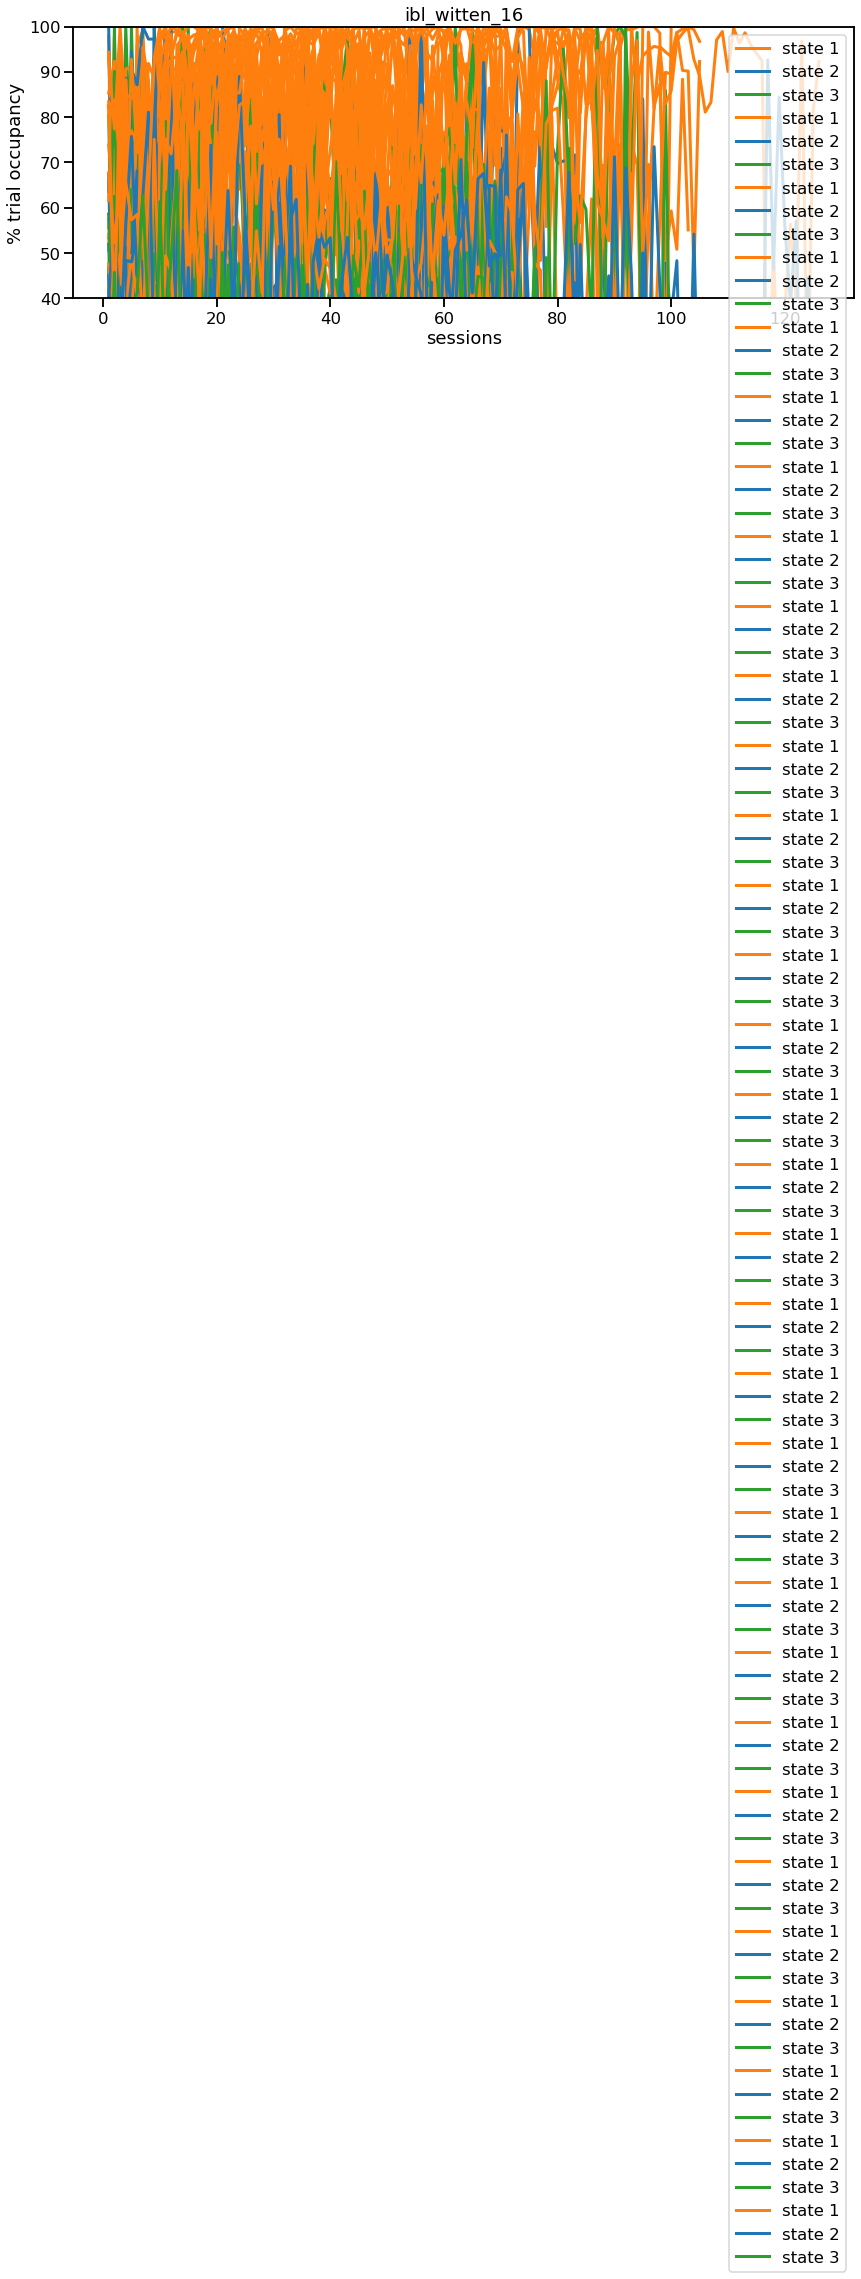

In [38]:
K = 3
allStateCount = np.empty((len(subjectsAll)), dtype=object)
allStateCorrect = np.empty((len(subjectsAll)), dtype=object)
allOverallCorrect = np.empty((len(subjectsAll)), dtype=object)
allOverallMixtureCorrect = np.empty((len(subjectsAll)), dtype=object)
allStateCorrectSeparate = np.empty((len(subjectsAll), 2), dtype=object) # separate for easy trials and hard trials
allOverallCorrectSeparate = np.empty((len(subjectsAll), 2), dtype=object) # separate for easy trials and hard trials
blocksStateRight = np.empty((len(subjectsAll)), dtype=object)
blocksStateLeft = np.empty((len(subjectsAll)), dtype=object)

allEmpiricalCorrect = np.empty((len(subjectsAll)), dtype=object)
allEmpiricalCorrectSeparate = np.empty((len(subjectsAll), 2), dtype=object)

fig, axes = plt.subplots(1, figsize = (14,5))#, dpi=400)
for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)
    biasedBlockTrials, biasedBlockStartInd, biasedBlockSession, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)
    # Plotting task occupancy of each state across sessions
    # fig, axes = plt.subplots(1, figsize = (14,5))#, dpi=400)
    axes.set_title(subject)
    allStateCount[idx] = plot_state_occupancy_sessions(allGamma[idx], sessInd, axes, colors=colorsStates)
    axes.set_ylim(-1,101)

    # plotting task accuracy in each state across sessions
    # fig, axes = plt.subplots(1, figsize = (14,5))#, dpi=400)
    axes.set_title(subject)
    _, _, allOverallCorrect[idx], allStateCorrect[idx] = accuracy_states_sessions(allGamma[idx], allPhi[idx], y, correctSide, sessInd)
    axes.set_ylim(40,100)

    # allOverallMixtureCorrect[idx] = accuracy_mixture_states_sessions(allGamma[idx], allPhi[idx], y, correctSide, sessInd)

    # calculating performance on easy trials for each state
    data = dfAll[dfAll['subject']==subject]
    dateToKeep = np.unique(data['date'])[0:sessStop]    
    dataTemp = pd.DataFrame(data.loc[data['date'].isin(list(dateToKeep))])
    contrastLeft=np.array(dataTemp['contrastLeft'])
    contrastRight=np.array(dataTemp['contrastRight'])
    easyTrials = (contrastLeft > 0.45).astype(int) | (contrastRight > 0.45).astype(int)
    correctSidee = np.array(dataTemp['correctSide'])

    # computing per state accuracy for easy trials
    N = y.shape[0]
    p_correct_states = np.ma.empty((N, K, 2)) # separate for easy and hard trials (last column) # 1 = easy, 0 = hard
    p_correct = np.ma.empty((N, 2))
    p_correct_states_sessions = np.ma.empty((len(sessInd)-1, K, 2))
    p_correct_sessions = np.ma.empty((len(sessInd)-1, 2))

    p_correct_states.mask = True
    p_correct.mask = True
    p_correct_states_sessions.mask = True
    p_correct_sessions.mask = True

    for session in range(0, len(sessInd)-1):
        for t in range(sessInd[session],sessInd[session+1]):
            for k in range(0,K):
                p_correct_states[t, k, easyTrials[t]] = allPhi[idx][t, k, correctSide[t]]
            if (np.ma.is_masked(p_correct_states[t, 0, 0]) == False): # means trial happened (not masked)
                p_correct[t, 0] = p_correct_states[t, :, 0] @ allGamma[idx][t] # hard trials
            if (np.ma.is_masked(p_correct_states[t, 0, 1]) == False): # means trial happened (not masked)
                p_correct[t, 1] = p_correct_states[t, :, 1] @ allGamma[idx][t] # easy trials
    
        p_correct_states_sessions[session] = np.nanmean(p_correct_states[sessInd[session]:sessInd[session+1]], axis=0) 
        p_correct_sessions[session] = np.nanmean(p_correct[sessInd[session]:sessInd[session+1]], axis=0)

    allStateCorrectSeparate[idx, 0] = 100 * p_correct_states_sessions[:, :, 0] # hard
    allStateCorrectSeparate[idx, 1] = 100 * p_correct_states_sessions[:, :, 1] # easy
    allOverallCorrectSeparate[idx, 0] = 100 * p_correct_sessions[:, 0]
    allOverallCorrectSeparate[idx, 1] = 100 * p_correct_sessions[:, 1]

    # empirical accuracy
    empiricalAccuracy = np.zeros((len(sessInd)-1))
    correct = correctSide == y
    for s in range(0,len(sessInd)-1):
        empiricalAccuracy[s] = np.mean(correct[sessInd[s]:sessInd[s+1]]) * 100
    allEmpiricalCorrect[idx] = empiricalAccuracy

    empiricalCorrectSeparate = np.ma.empty((N, 2))
    empiricalCorrectSeparate.mask = True
    empiricalCorrectSeparateSession = np.ma.empty((len(sessInd)-1, 2))
    empiricalCorrectSeparateSession.mask = True
    for session in range(0, len(sessInd)-1):
        for t in range(sessInd[session],sessInd[session+1]):
            empiricalCorrectSeparate[t, easyTrials[t]] = correct[t]
        empiricalCorrectSeparateSession[session] = np.nanmean(empiricalCorrectSeparate[sessInd[session]:sessInd[session+1]], axis=0)
    allEmpiricalCorrectSeparate[idx, 0] = 100 * empiricalCorrectSeparateSession[:, 0]
    allEmpiricalCorrectSeparate[idx, 1] = 100 * empiricalCorrectSeparateSession[:, 1]

    # Plotting alignment of biased states with biased blocks
    # fig, axes = plt.subplots(1, figsize=(14,5))
    # blocksStateRight[idx], blocksStateLeft[idx] = plot_aligned_fraction_blocks_state(allGamma[idx], sessInd, biasedBlockTrials, biasedBlockSession, axes)
    # axes.axvline(firstBlockSession+1, color='gray', zorder=0)

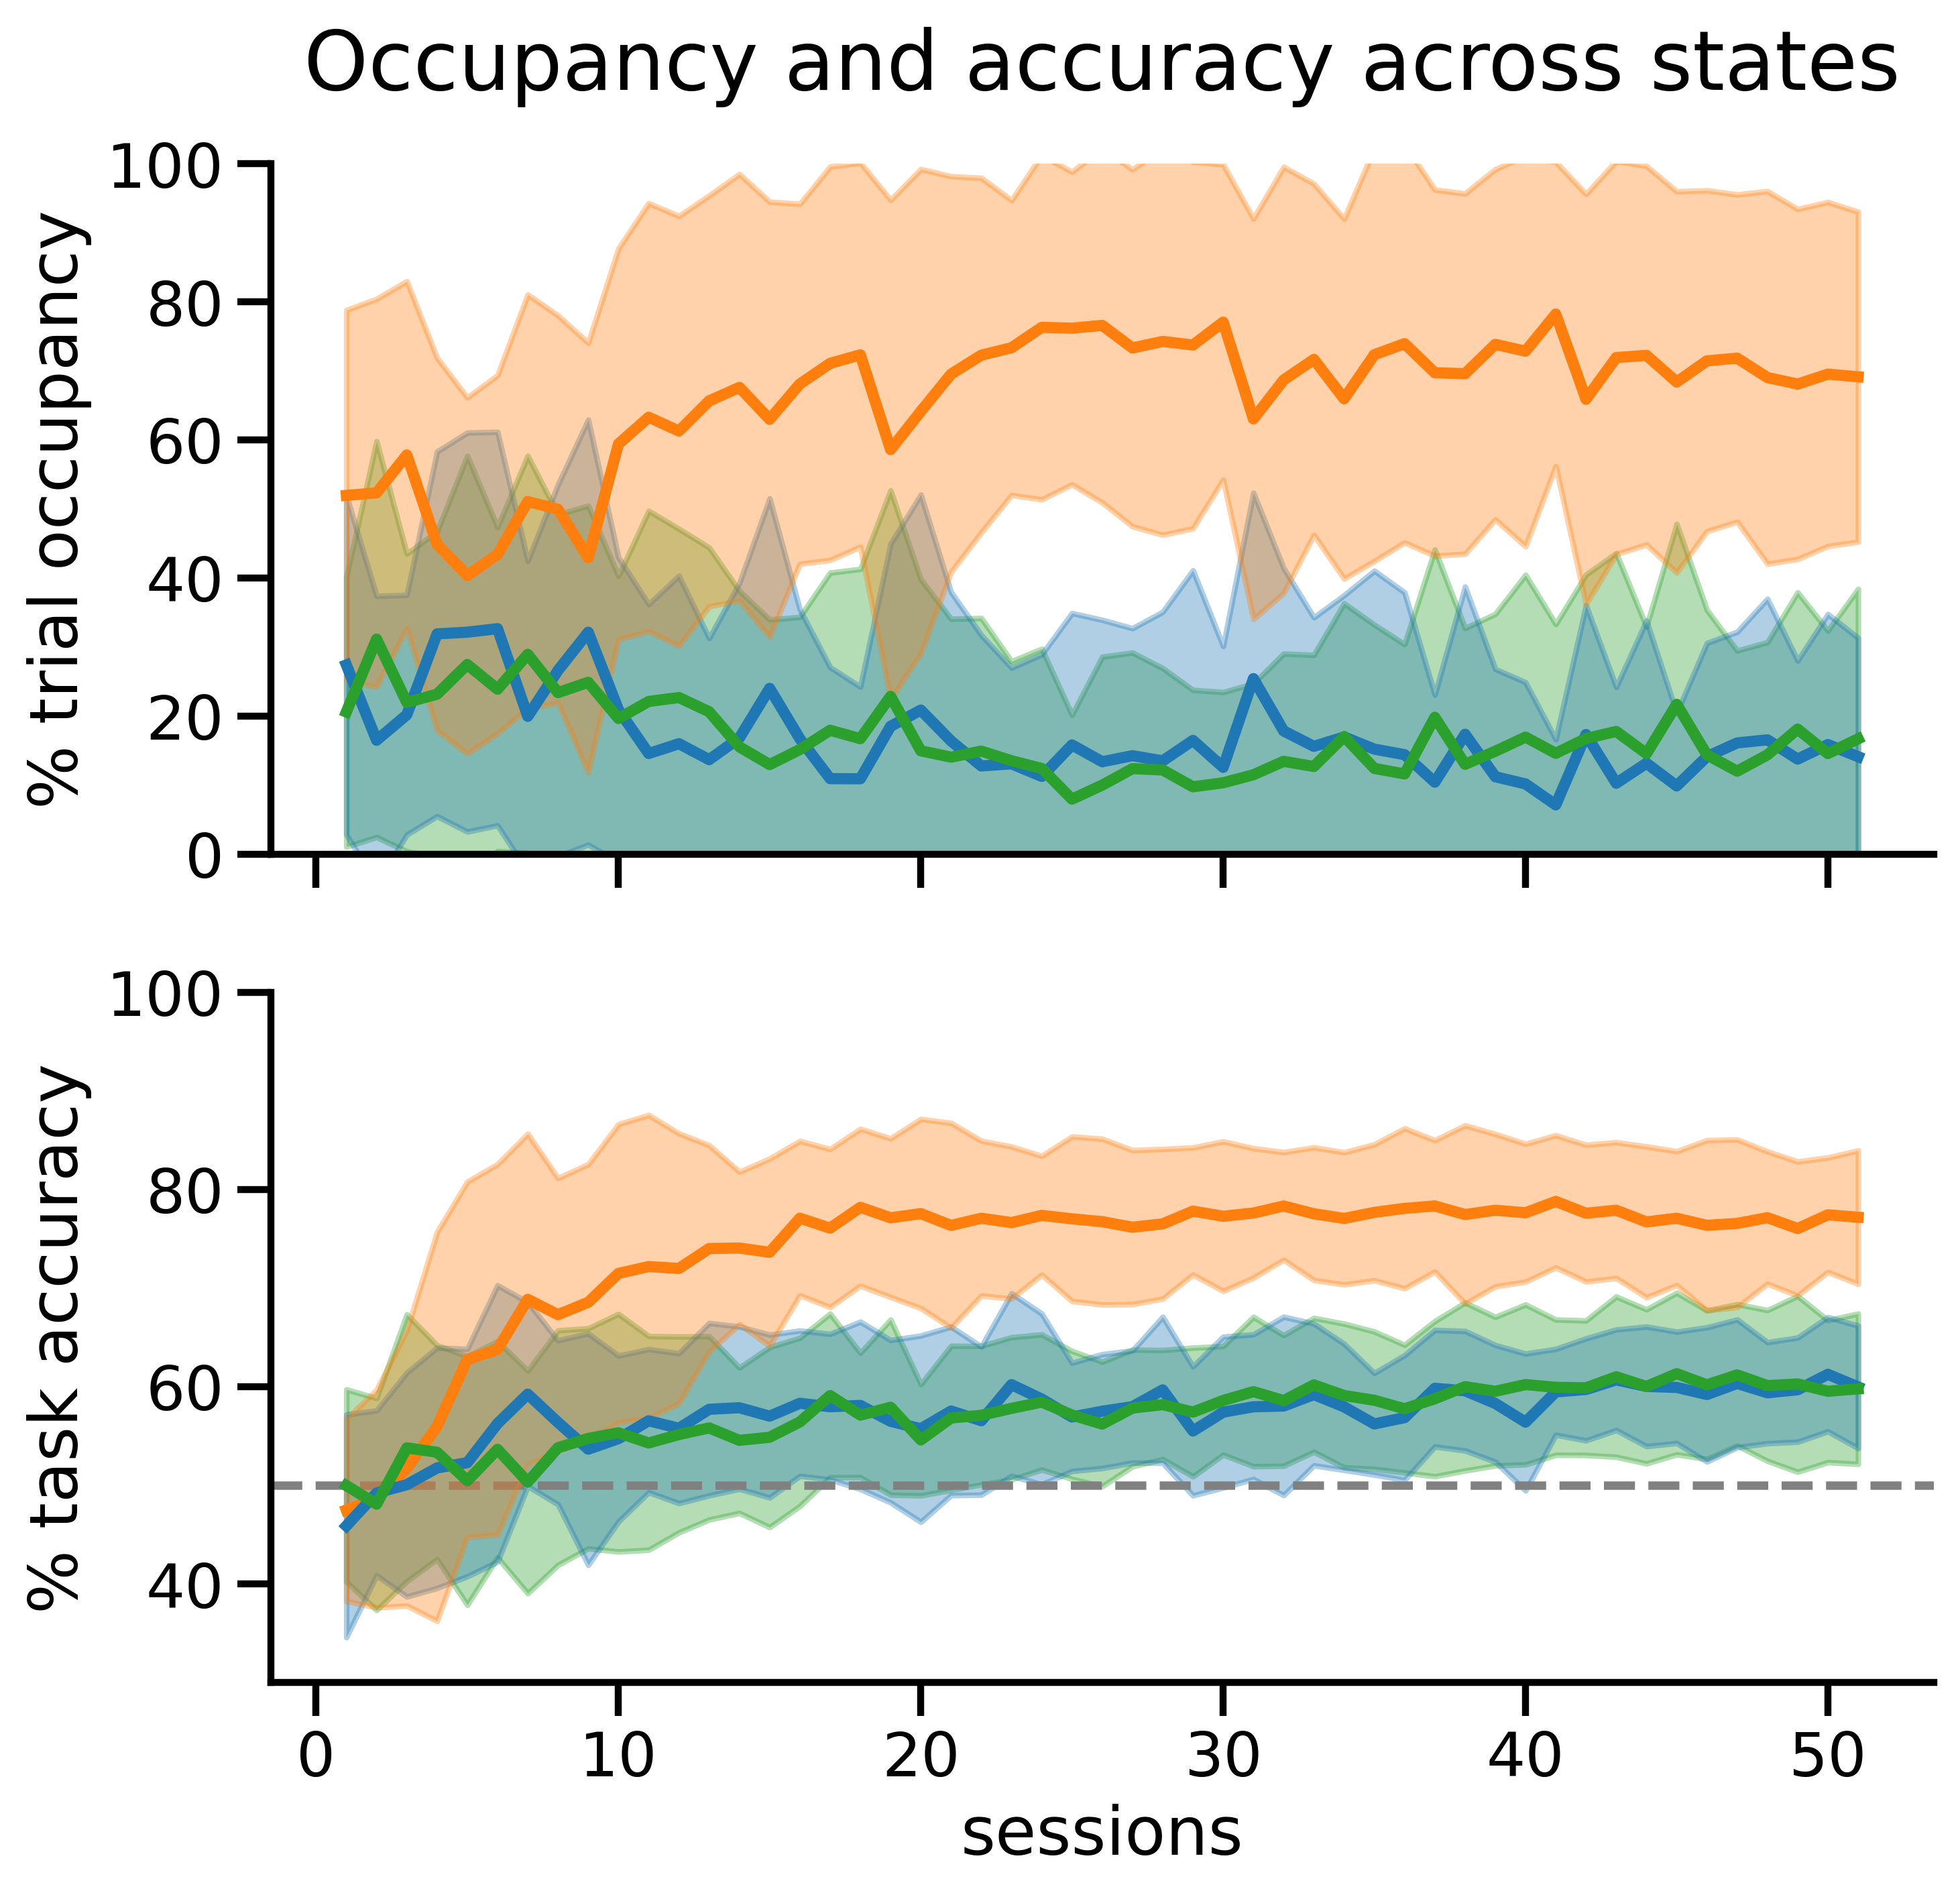

In [29]:
fig, axes = plt.subplots(2, figsize = (8,7.5), sharex=True, dpi=400) 
maxSess = 51
bestSigmaInd = 7
K = 3

arrStateCount = np.ma.empty((maxSess,K,len(subjectsAll)))
arrStateCount.mask = True

for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx] 
    _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)

    stop = min(len(sessInd)-1, maxSess)
    arrStateCount[:stop, :K, idx] = allStateCount[idx][:stop]
    # for k in range(0,K): # not plotting per-animal lines
    #     axes[0].plot(range(1,maxSess+1), arrStateCount[:,k,idx], color=colorsStates[k], linewidth=3, label=f'state {k+1}', alpha=0.08)
   
for k in range(0,K):
    axes[0].plot(range(1,maxSess+1), np.nanmean(arrStateCount[:,k,:], axis=1), color=colorsStates[k], linewidth=3, label=f'state {k+1}', zorder=3)
    axes[0].fill_between(range(1,maxSess+1), np.nanmean(arrStateCount[:,k,:], axis=1)-np.nanstd(arrStateCount[:,k,:], axis=1), np.nanmean(arrStateCount[:,k,:], axis=1)+np.nanstd(arrStateCount[:,k,:], axis=1), alpha=0.35, zorder=2-k, color=colorsStates[k])

axes[0].set_ylabel('% trial occupancy')
axes[0].set_xlabel('')
axes[0].set_ylim(0,100)
axes[0].legend(loc='upper left')

arrStateCorrect = np.ma.empty((maxSess,K,len(subjectsAll)))
arrStateCorrect.mask = True

arrOverallCorrect = np.ma.empty((maxSess,len(subjectsAll)))
arrOverallCorrect.mask = True

axes[1].axhline(50,color='gray',linestyle='dashed')
for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx] 
    _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)

    stop = min(len(sessInd)-1, maxSess)
    arrStateCorrect[:stop, :K, idx] = allStateCorrect[idx][:stop]
    arrOverallCorrect[:stop, idx] = allOverallCorrect[idx][:stop]
    
    # for k in range(0,K): # not plotting per-animal lines
    #     axes[1].plot(range(1,maxSess+1), arrStateCorrect[:,k,idx], color=colorsStates[k], linewidth=3, label=f'state {k+1}', alpha=0.08)

# axes[1].plot(range(1,maxSess+1), np.nanmean(arrOverallCorrect[:,:], axis=1), color='black', linewidth=3, label=f'state {k+1}', zorder=3)
for k in range(0,K):
    axes[1].plot(range(1,maxSess+1), np.nanmean(arrStateCorrect[:,k,:], axis=1), color=colorsStates[k], linewidth=3, label=f'state {k+1}', zorder=3)
    axes[1].fill_between(range(1,maxSess+1), np.nanmean(arrStateCorrect[:,k,:], axis=1)-np.nanstd(arrStateCorrect[:,k,:], axis=1), np.nanmean(arrStateCorrect[:,k,:], axis=1)+np.nanstd(arrStateCorrect[:,k,:], axis=1), alpha=0.35, zorder=2-k, color=colorsStates[k])
axes[1].set_ylabel('% task accuracy')
axes[1].set_xlabel('sessions')
axes[1].set_ylim(30,100)
axes[1].legend(loc='upper left')
axes[0].spines[['right', 'top']].set_visible(False)
axes[1].spines[['right', 'top']].set_visible(False)
axes[0].set_title('Occupancy and accuracy across states', size=22, pad=20)
axes[0].get_legend().remove()
axes[1].get_legend().remove()
plt.savefig(f'../figures/Occupancy_accuracy_states_allAnimals', bbox_inches='tight', dpi=400)

In [36]:
# fig, axes = plt.subplots(1, figsize = (12.5,5), sharex=True, dpi=400) 
# maxSess = 18
# bestSigmaInd = 7
# K = 3

# arrStateCount = np.ma.empty((maxSess,K,len(subjectsAll)))
# arrStateCount.mask = True

# for idx in range(0,len(subjectsAll)):
#     subject = subjectsAll[idx] 
#     _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)

#     stop = min(len(sessInd)-1, maxSess)
#     arrStateCount[:stop, :K, idx] = allStateCount[idx][:stop]
#     # for k in range(0,K): # not plotting per-animal lines
#     #     axes[0].plot(range(1,maxSess+1), arrStateCount[:,k,idx], color=colorsStates[k], linewidth=3, label=f'state {k+1}', alpha=0.08)
   
# for k in range(0,K):
#     axes.plot(range(1,maxSess+1), np.nanmean(arrStateCount[:,k,:], axis=1), color=colorsStates[k], linewidth=3, label=f'state {k+1}', zorder=3)
#     axes.fill_between(range(1,maxSess+1), np.nanmean(arrStateCount[:,k,:], axis=1)-np.nanstd(arrStateCount[:,k,:], axis=1), np.nanmean(arrStateCount[:,k,:], axis=1)+np.nanstd(arrStateCount[:,k,:], axis=1), alpha=0.35, zorder=2-k, color=colorsStates[k])

# axes.set_ylabel('% trial occupancy')
# axes.set_xlabel('')
# axes.set_ylim(0,100)
# axes.legend(loc='upper left')
# axes.set_xlabel('session')
# axes.spines[['right', 'top']].set_visible(False)
# axes.set_xticks(range(0,18,5),range(0,18,5))
# axes.set_title('Fraction state occupancy during early sessions', size=22)

/Users/lencacuturela/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1550: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


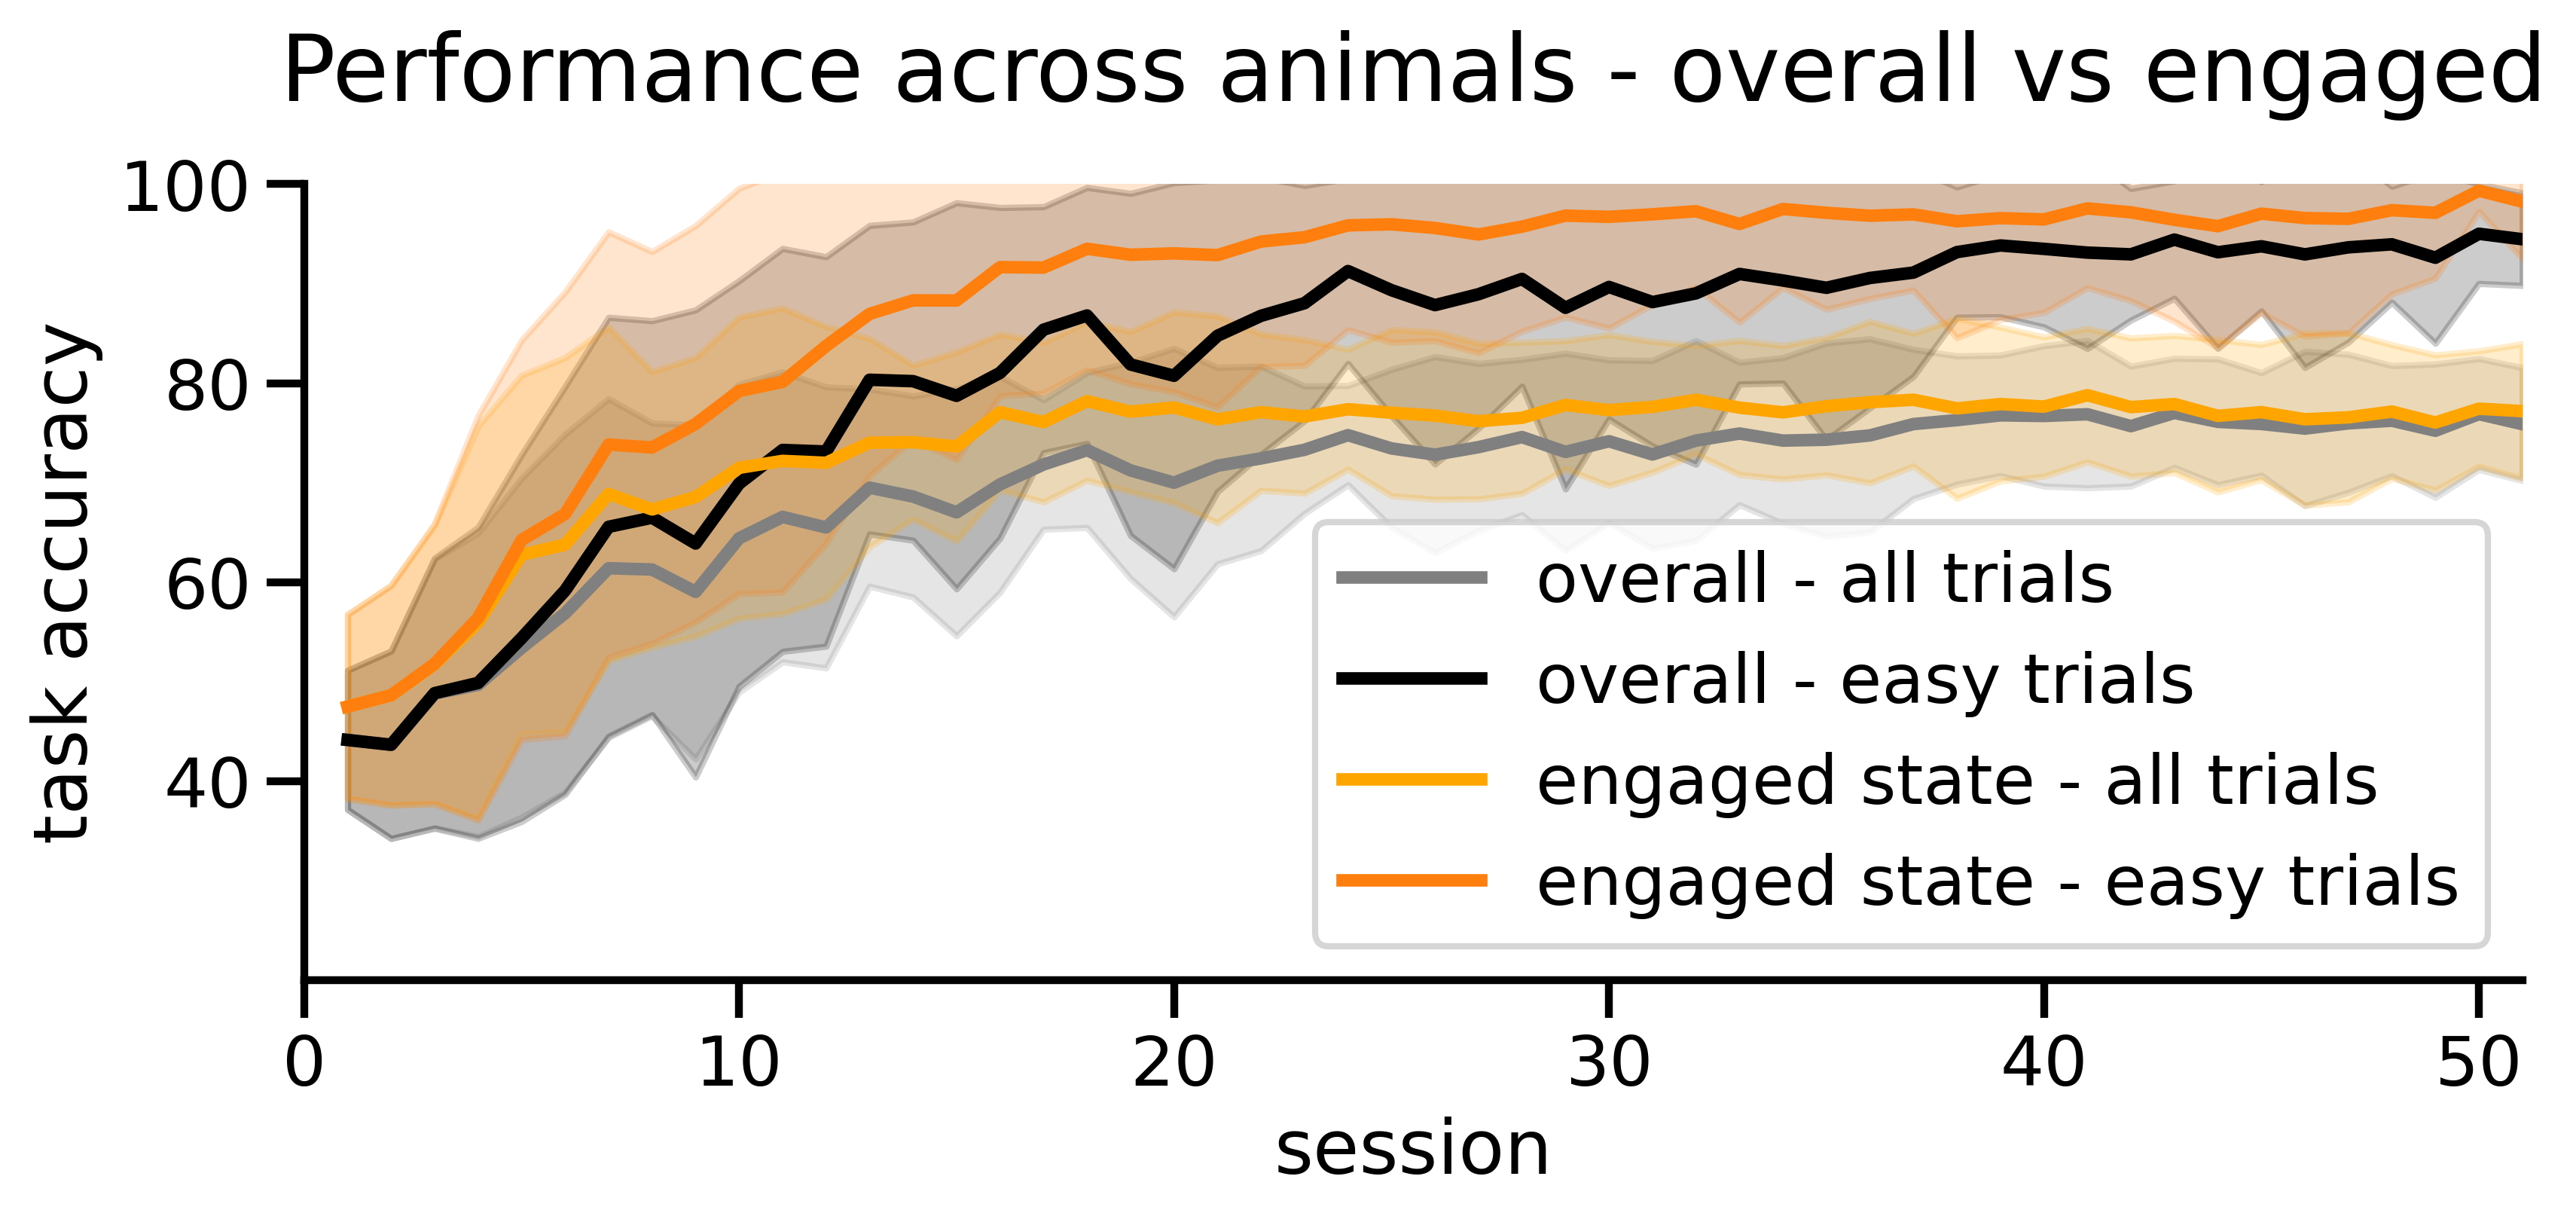

In [43]:
maxSess = 51

arrStateSeparateCorrect = np.ma.empty((maxSess,K,len(subjectsAll), 2))
arrStateSeparateCorrect.mask = True

arrOverallSeparateCorrect = np.ma.empty((maxSess,len(subjectsAll), 2))
arrOverallSeparateCorrect.mask = True

arrEmpiricalCorrect = np.ma.empty((maxSess,len(subjectsAll)))
arrEmpiricalCorrect.mask = True

arrEmpiricalCorrectSeparate = np.ma.empty((maxSess,len(subjectsAll), 2))
arrEmpiricalCorrectSeparate.mask = True

for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx] 
    _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)

    stop = min(len(sessInd)-1, maxSess)
    arrStateSeparateCorrect[:stop, :K, idx, 0] = allStateCorrectSeparate[idx, 0][:stop] # hard
    arrStateSeparateCorrect[:stop, :K, idx, 1] = allStateCorrectSeparate[idx, 1][:stop] # easy
    arrOverallSeparateCorrect[:stop, idx, 0] = allOverallCorrectSeparate[idx, 0][:stop]
    arrOverallSeparateCorrect[:stop, idx, 1] = allOverallCorrectSeparate[idx, 1][:stop]


    arrEmpiricalCorrect[:stop, idx] = allEmpiricalCorrect[idx][:stop] 
    arrEmpiricalCorrectSeparate[:stop, idx, 0] = allEmpiricalCorrectSeparate[idx, 0][:stop] 
    arrEmpiricalCorrectSeparate[:stop, idx, 1] = allEmpiricalCorrectSeparate[idx, 1][:stop] 
    

fig, axes = plt.subplots(1, figsize = (9.5,3.5), dpi=400) 
# performance in general
axes.fill_between(range(1,maxSess+1), np.nanmean(arrOverallCorrect, axis=1)-np.nanstd(arrOverallCorrect, axis=1), np.nanmean(arrOverallCorrect, axis=1)+np.nanstd(arrOverallCorrect, axis=1), alpha=0.2, zorder=0, color="gray")
axes.plot(range(1,maxSess+1), np.nanmean(arrOverallCorrect, axis=1), color="gray", linewidth=3, label='overall - all trials', zorder=1)
axes.fill_between(range(1,maxSess+1), np.nanmean(arrOverallSeparateCorrect[:,:,1], axis=1)-np.nanstd(arrOverallSeparateCorrect[:,:,1], axis=1), np.nanmean(arrOverallSeparateCorrect[:,:,1], axis=1)+np.nanstd(arrOverallSeparateCorrect[:,:,1], axis=1), alpha=0.2, zorder=0, color="black")
axes.plot(range(1,maxSess+1), np.nanmean(arrOverallSeparateCorrect[:,:,1], axis=1), color="black", linewidth=3, label='overall - easy trials', zorder=1)


# performance in state 1
axes.fill_between(range(1,maxSess+1), np.nanmean(arrStateCorrect[:,0,:], axis=1)-np.nanstd(arrStateCorrect[:,0,:], axis=1), np.nanmean(arrStateCorrect[:,0,:], axis=1)+np.nanstd(arrStateCorrect[:,0,:], axis=1), alpha=0.2, zorder=0, color="orange")
axes.plot(range(1,maxSess+1), np.nanmean(arrStateCorrect[:,0,:], axis=1), color="orange", linewidth=3, label='engaged state - all trials', zorder=1)
axes.fill_between(range(1,maxSess+1), np.nanmean(arrStateSeparateCorrect[:,0,:,1], axis=1)-np.nanstd(arrStateSeparateCorrect[:,0,:,1], axis=1), np.nanmean(arrStateSeparateCorrect[:,0,:,1], axis=1)+np.nanstd(arrStateSeparateCorrect[:,0,:,1], axis=1), alpha=0.2, zorder=0, color='tab:orange')
axes.plot(range(1,maxSess+1), np.nanmean(arrStateSeparateCorrect[:,0,:,1], axis=1), color="tab:orange", linewidth=3, label='engaged state - easy trials', zorder=1)

axes.set_ylabel('task accuracy')
axes.set_xlabel('session')
axes.set_yticks([40,60,80,100])
axes.set_ylim(20,100)
axes.set_xlim(0,51)
axes.axhline(0.5, color="black", linestyle="--", lw=1, alpha=0.3, zorder=0)
axes.spines[['right', 'top']].set_visible(False)
axes.legend(loc='lower right')
axes.set_title('Performance across animals - overall vs engaged' ,size=22, pad=20)
plt.savefig(f'../figures/Accuracy_TotalvsEngaged_allAnimals', bbox_inches='tight', dpi=400)

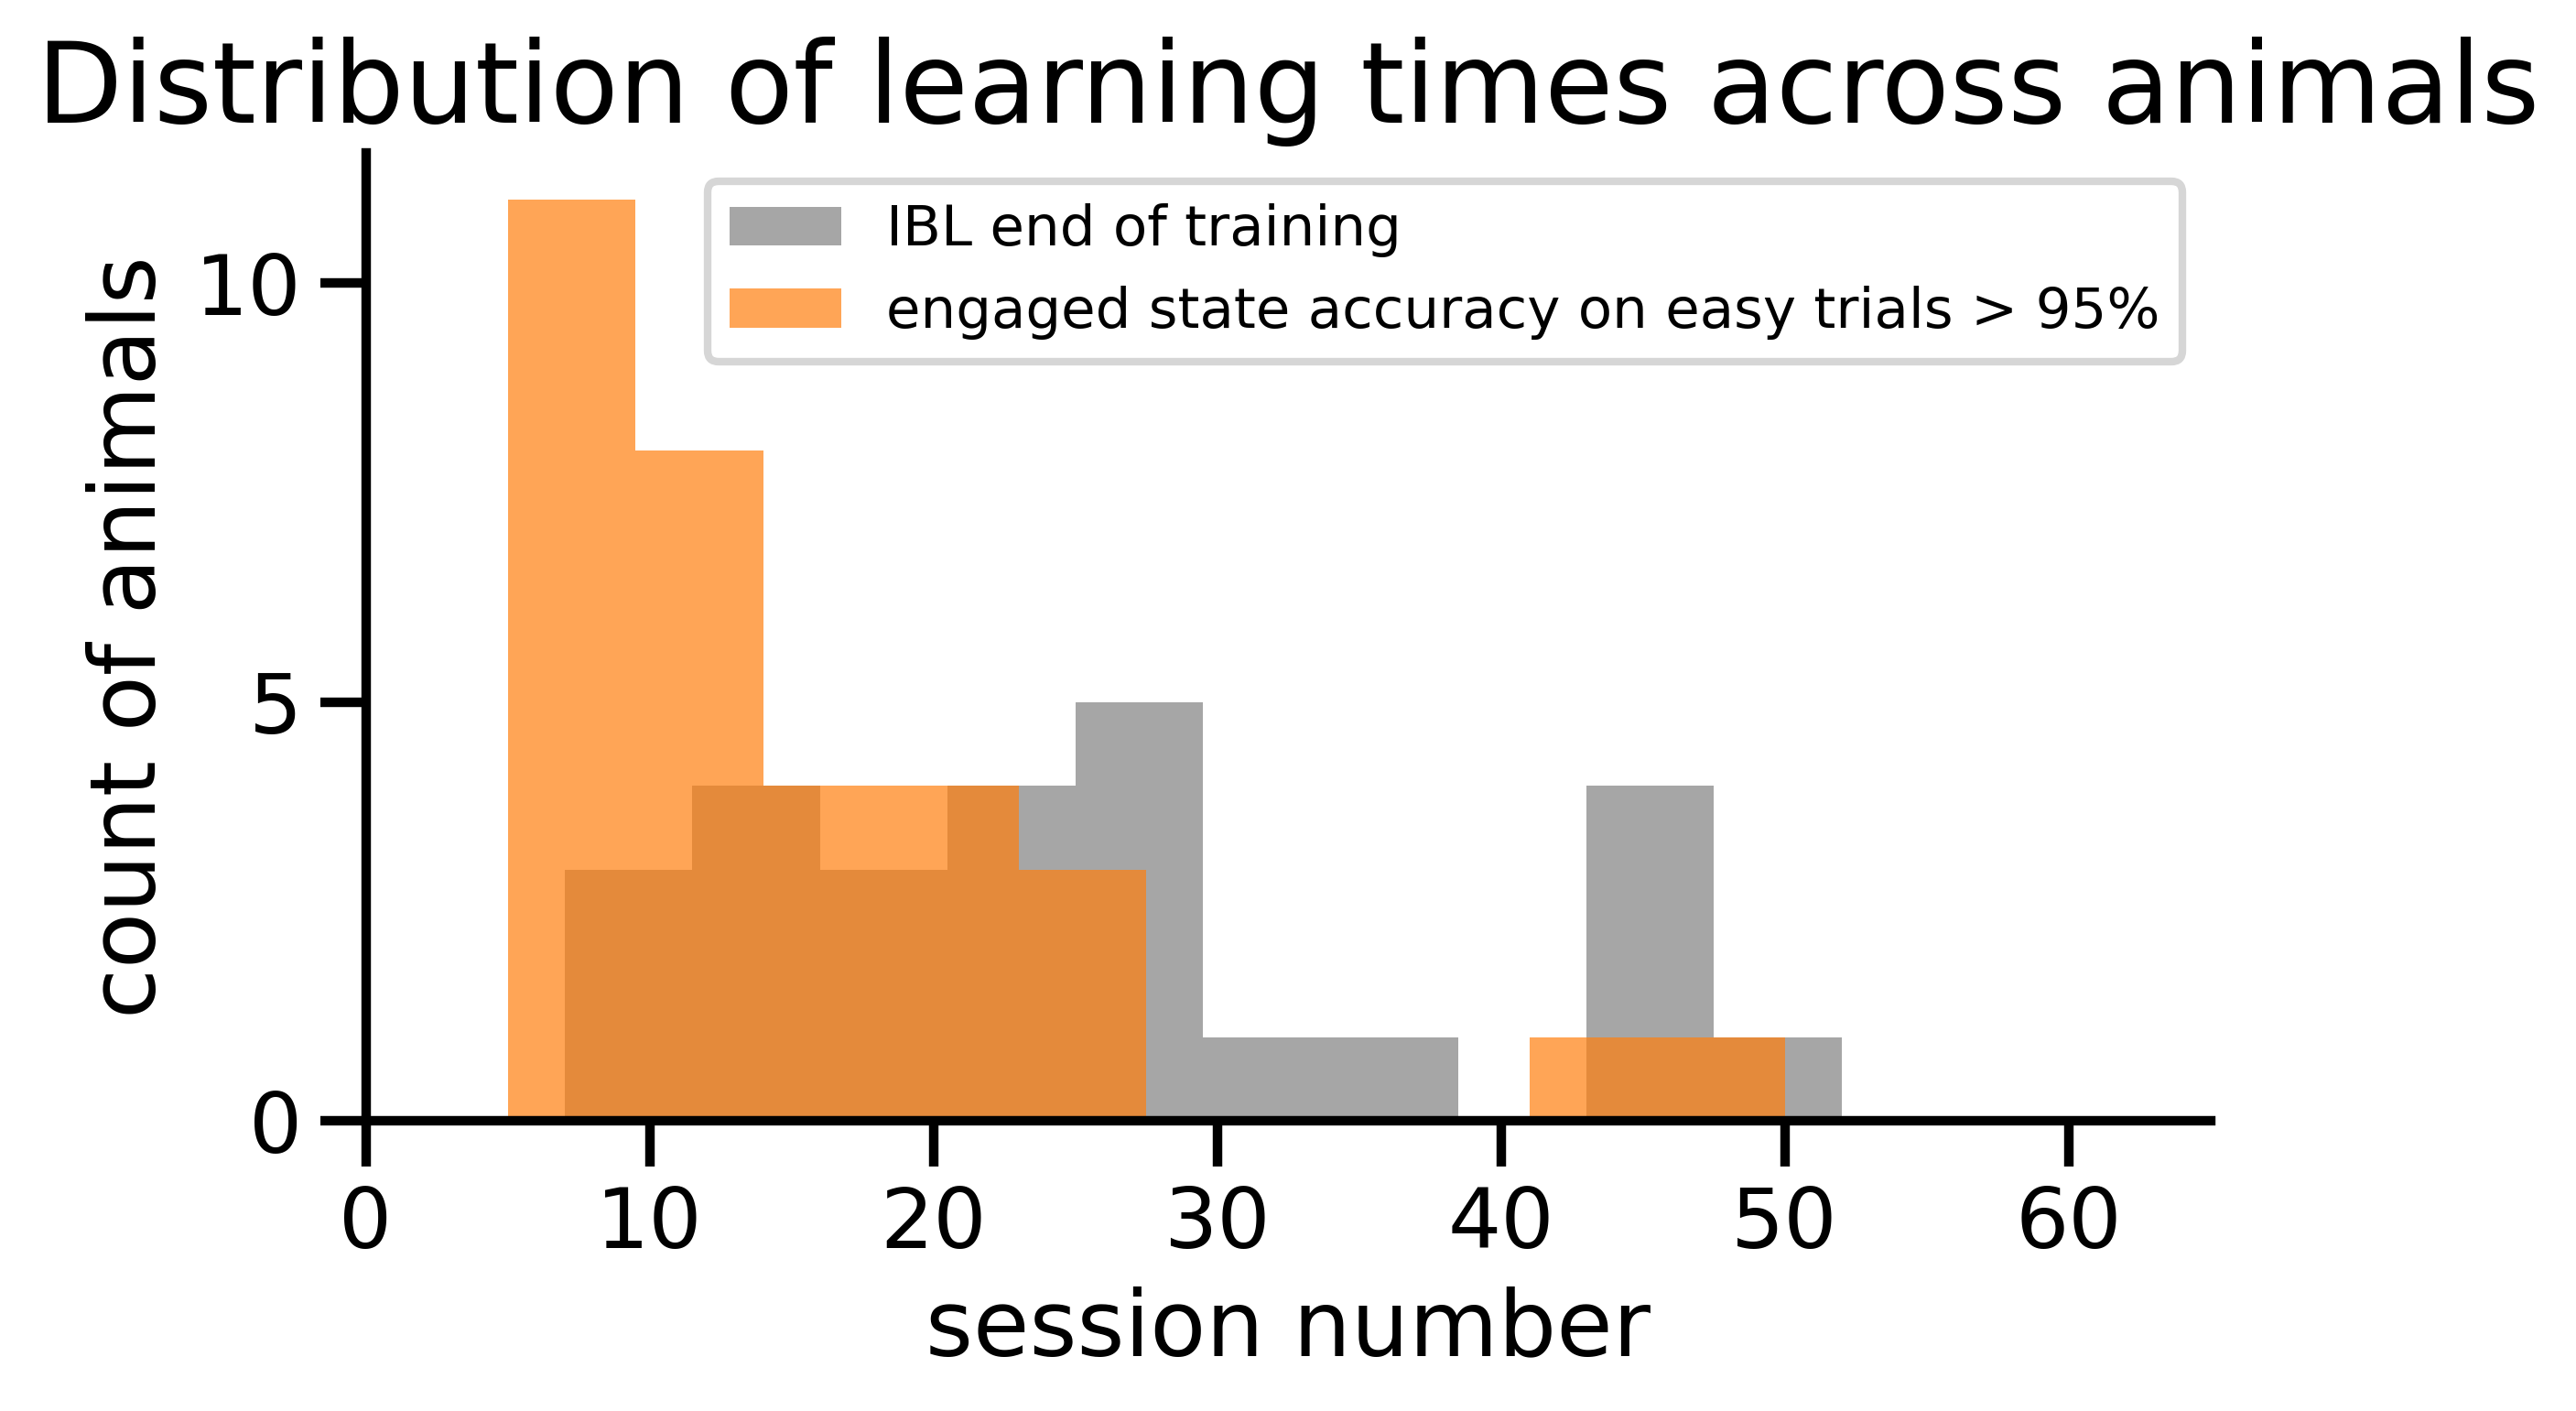

In [61]:
# Learning across animals - Distribution
# Time it takes for accuracy in engaged state to reach threshold 
from astropy.stats import bayesian_blocks
treshold = 95
def learning_time(accuracySession, treshold=0.95): # decided for accuracy on easy trials  
    sessions = accuracySession.shape[0]
    time = -1
    for t in range(1,sessions):
        if (np.mean(accuracySession[t-1:t+1]) >= treshold):
            time = t
            break 
    return time

learningTimes = np.zeros((len(subjectsAll)))
firstBlockSession = np.zeros((len(subjectsAll)))
for idx in range(0, len(subjectsAll)):
    learningTimes[idx] = learning_time(arrStateSeparateCorrect[:,0,idx, 1], treshold=treshold)

    subject = subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)
    _, _, _, firstBlockSession[idx] = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)

fig, axes = plt.subplots(1, figsize = (6.5, 3.5), dpi=400) 
axes.hist(firstBlockSession, bins=10, color='gray', alpha=0.7, label='IBL end of training')
axes.hist(learningTimes, bins=10, color='tab:orange', alpha=0.7, label='engaged state accuracy on easy trials > ' + str(treshold) +'%')
axes.set_xlim(0,65)
axes.spines[['right', 'top']].set_visible(False)
axes.set_xlabel('session number')
axes.set_ylabel('count of animals')
axes.set_title('Distribution of learning times across animals', size=22)
axes.set_yticks(range(0,15,5), range(0,15,5))
axes.legend(loc='upper right', prop={'size': 11})
plt.savefig(f'../figures/LearningTimes_Distribution_allAnimals', bbox_inches='tight', dpi=400)

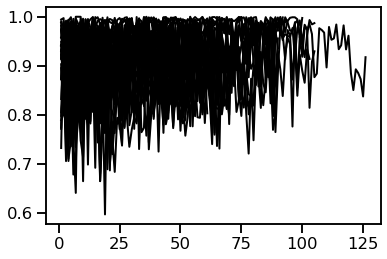

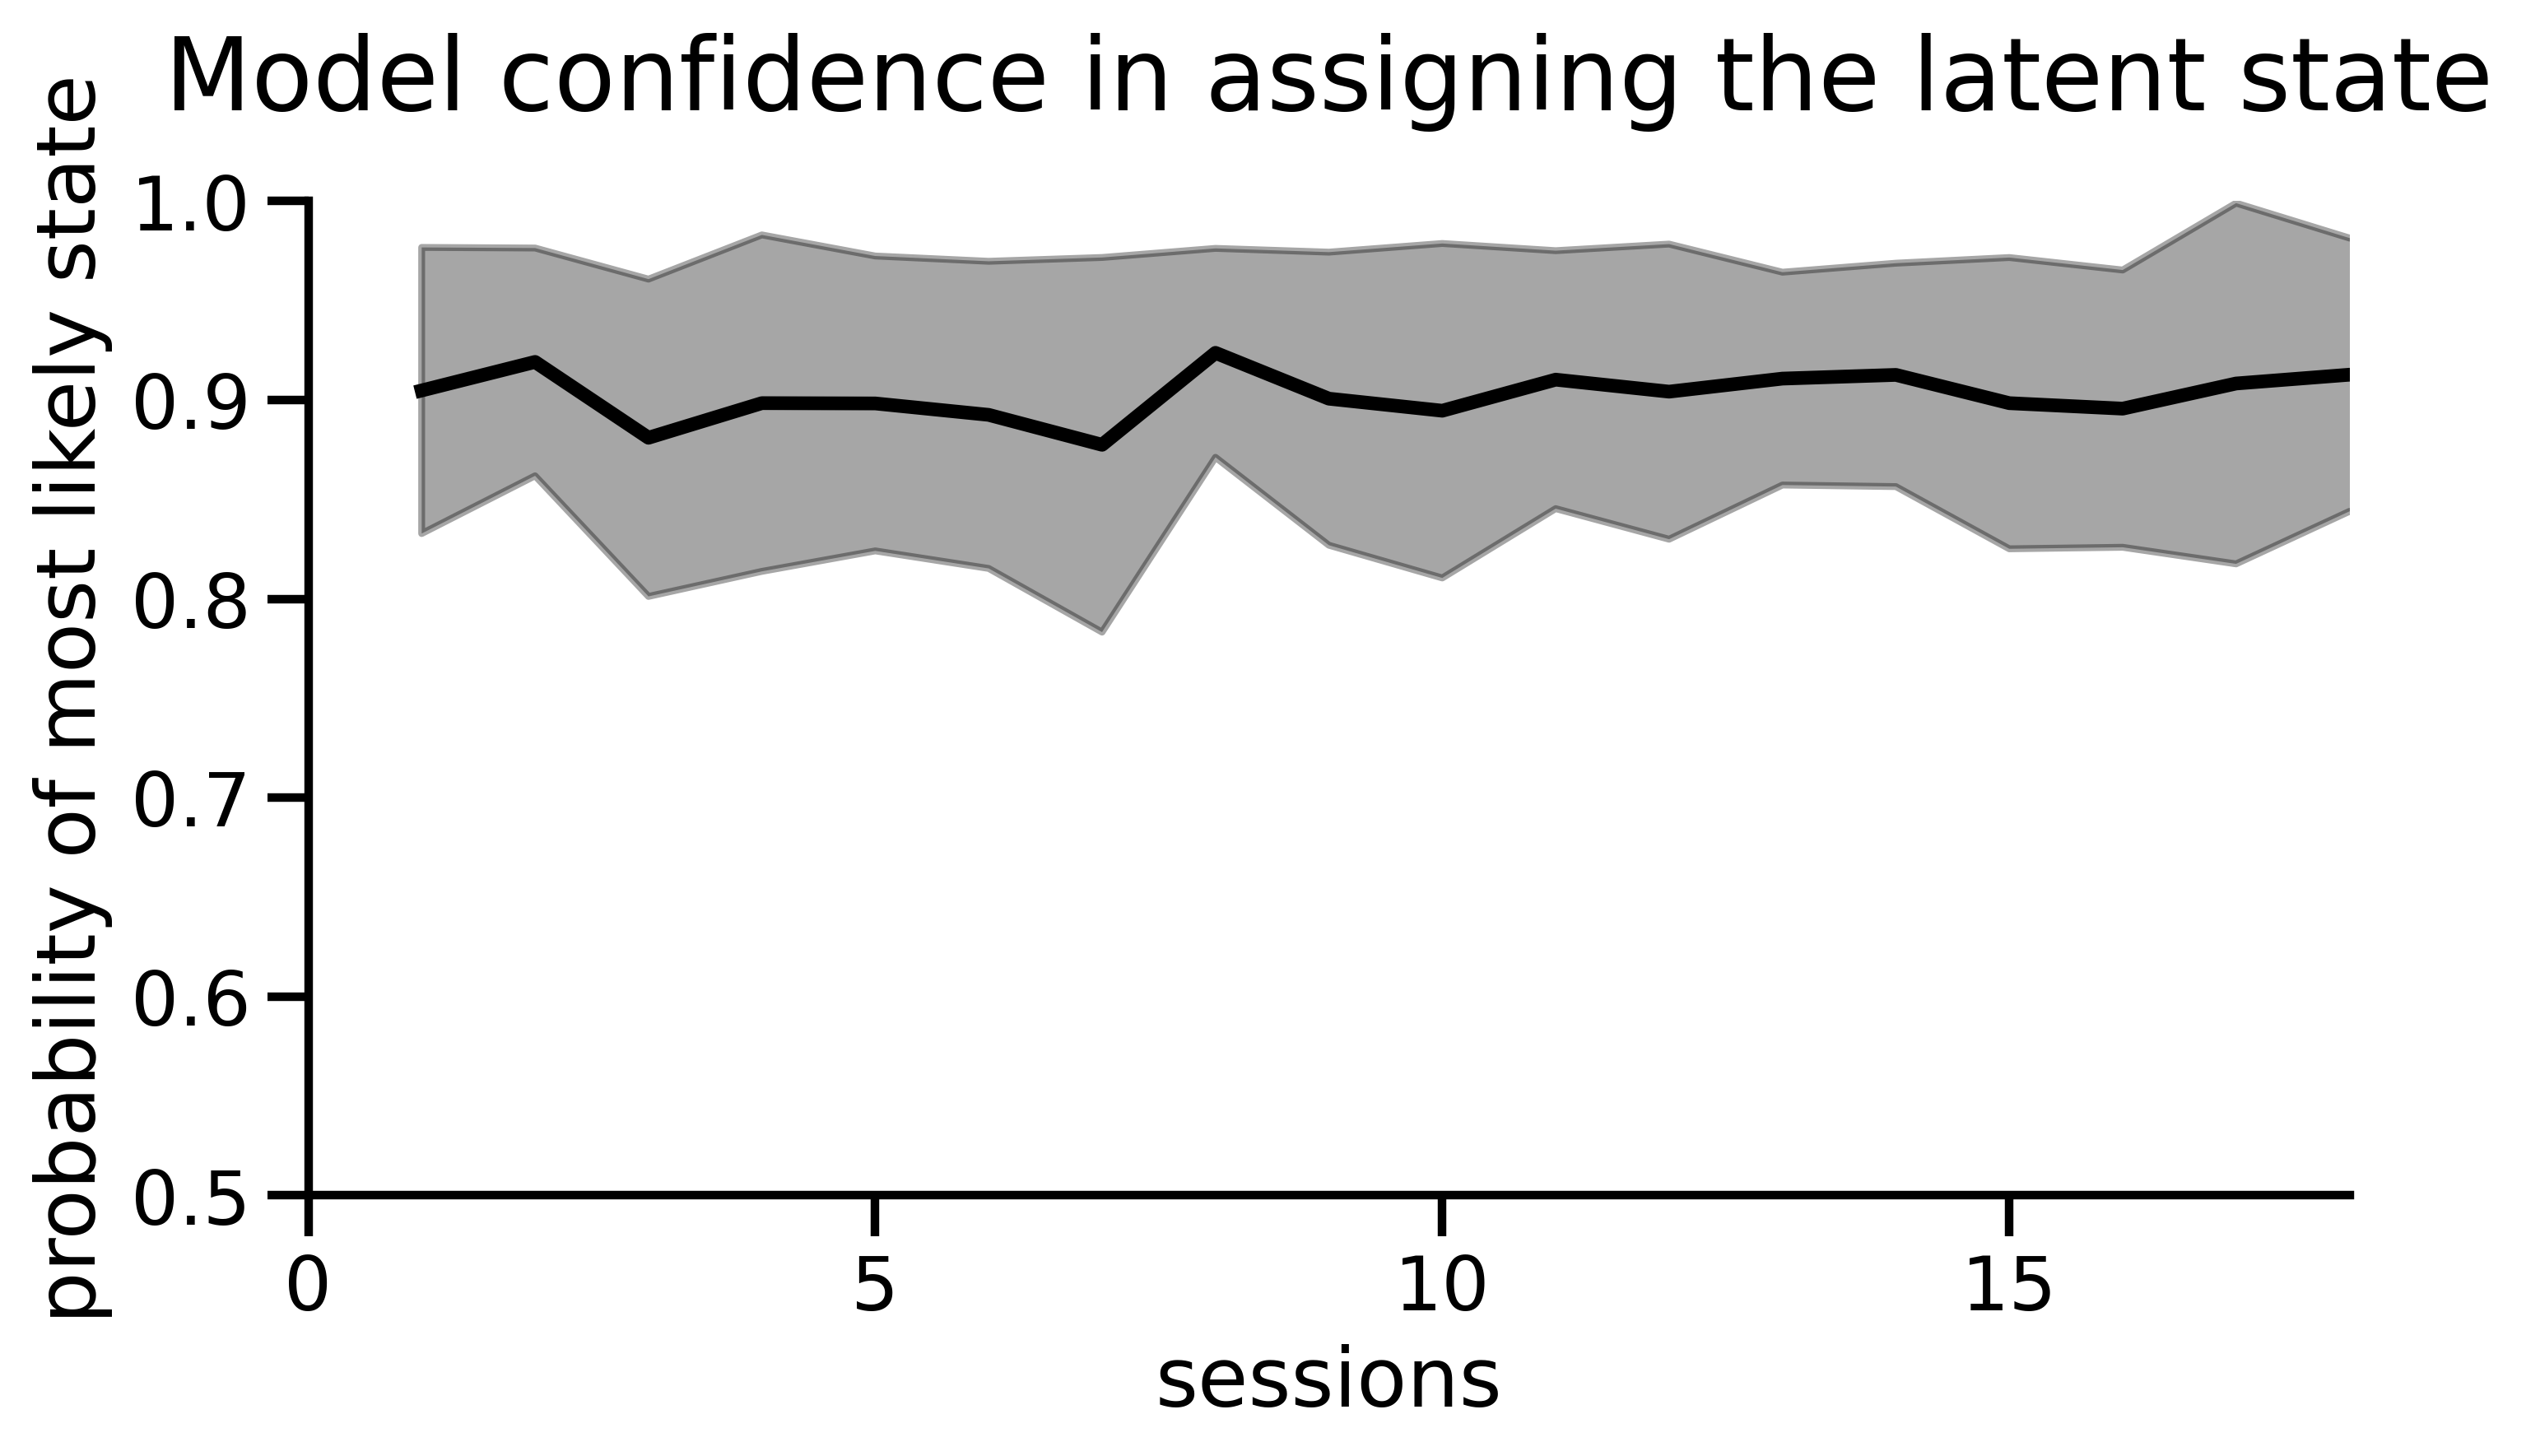

In [175]:
# Probability of most likely state - average across animals
maxSess = 51
bestSigmaInd = 7
K = 3

arrProbStateMax = np.ma.empty((maxSess,len(subjectsAll)))
arrProbStateMax.mask = True

fig, axes = plt.subplots(1) 
for idx in range(0,len(subjectsAll)):
    subject = subjectsAll[idx] 
    _, _, sessInd, _ = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)

    probMaxSession = distribution_most_likely_state(allGamma[idx], sessInd, axes)
    
    stop = min(len(sessInd)-1, maxSess)
    arrProbStateMax[:stop, idx] = probMaxSession[:stop]

fig, axes = plt.subplots(1, figsize = (8,4), sharex=True, dpi=400) 
axes.plot(range(1,maxSess+1), np.nanmean(arrProbStateMax, axis=1), color='black', linewidth=3)
axes.fill_between(range(1,maxSess+1), np.nanmean(arrProbStateMax, axis=1)-np.nanstd(arrProbStateMax, axis=1), np.nanmean(arrProbStateMax, axis=1)+np.nanstd(arrProbStateMax, axis=1), alpha=0.35, color='black')
axes.set_ylabel('probability of most likely state')
axes.set_title('Model confidence in assigning the latent state', size=22, pad=20)
axes.set_xlabel('sessions')
axes.set_ylim(0.5,1)
axes.spines[['right', 'top']].set_visible(False)
axes.set_xticks(range(0,18,5),range(0,18,5))
axes.set_xlim(0,18)
plt.savefig(f'../figures/Probability_most_likely_state_allAnimals', bbox_inches='tight', dpi=400)

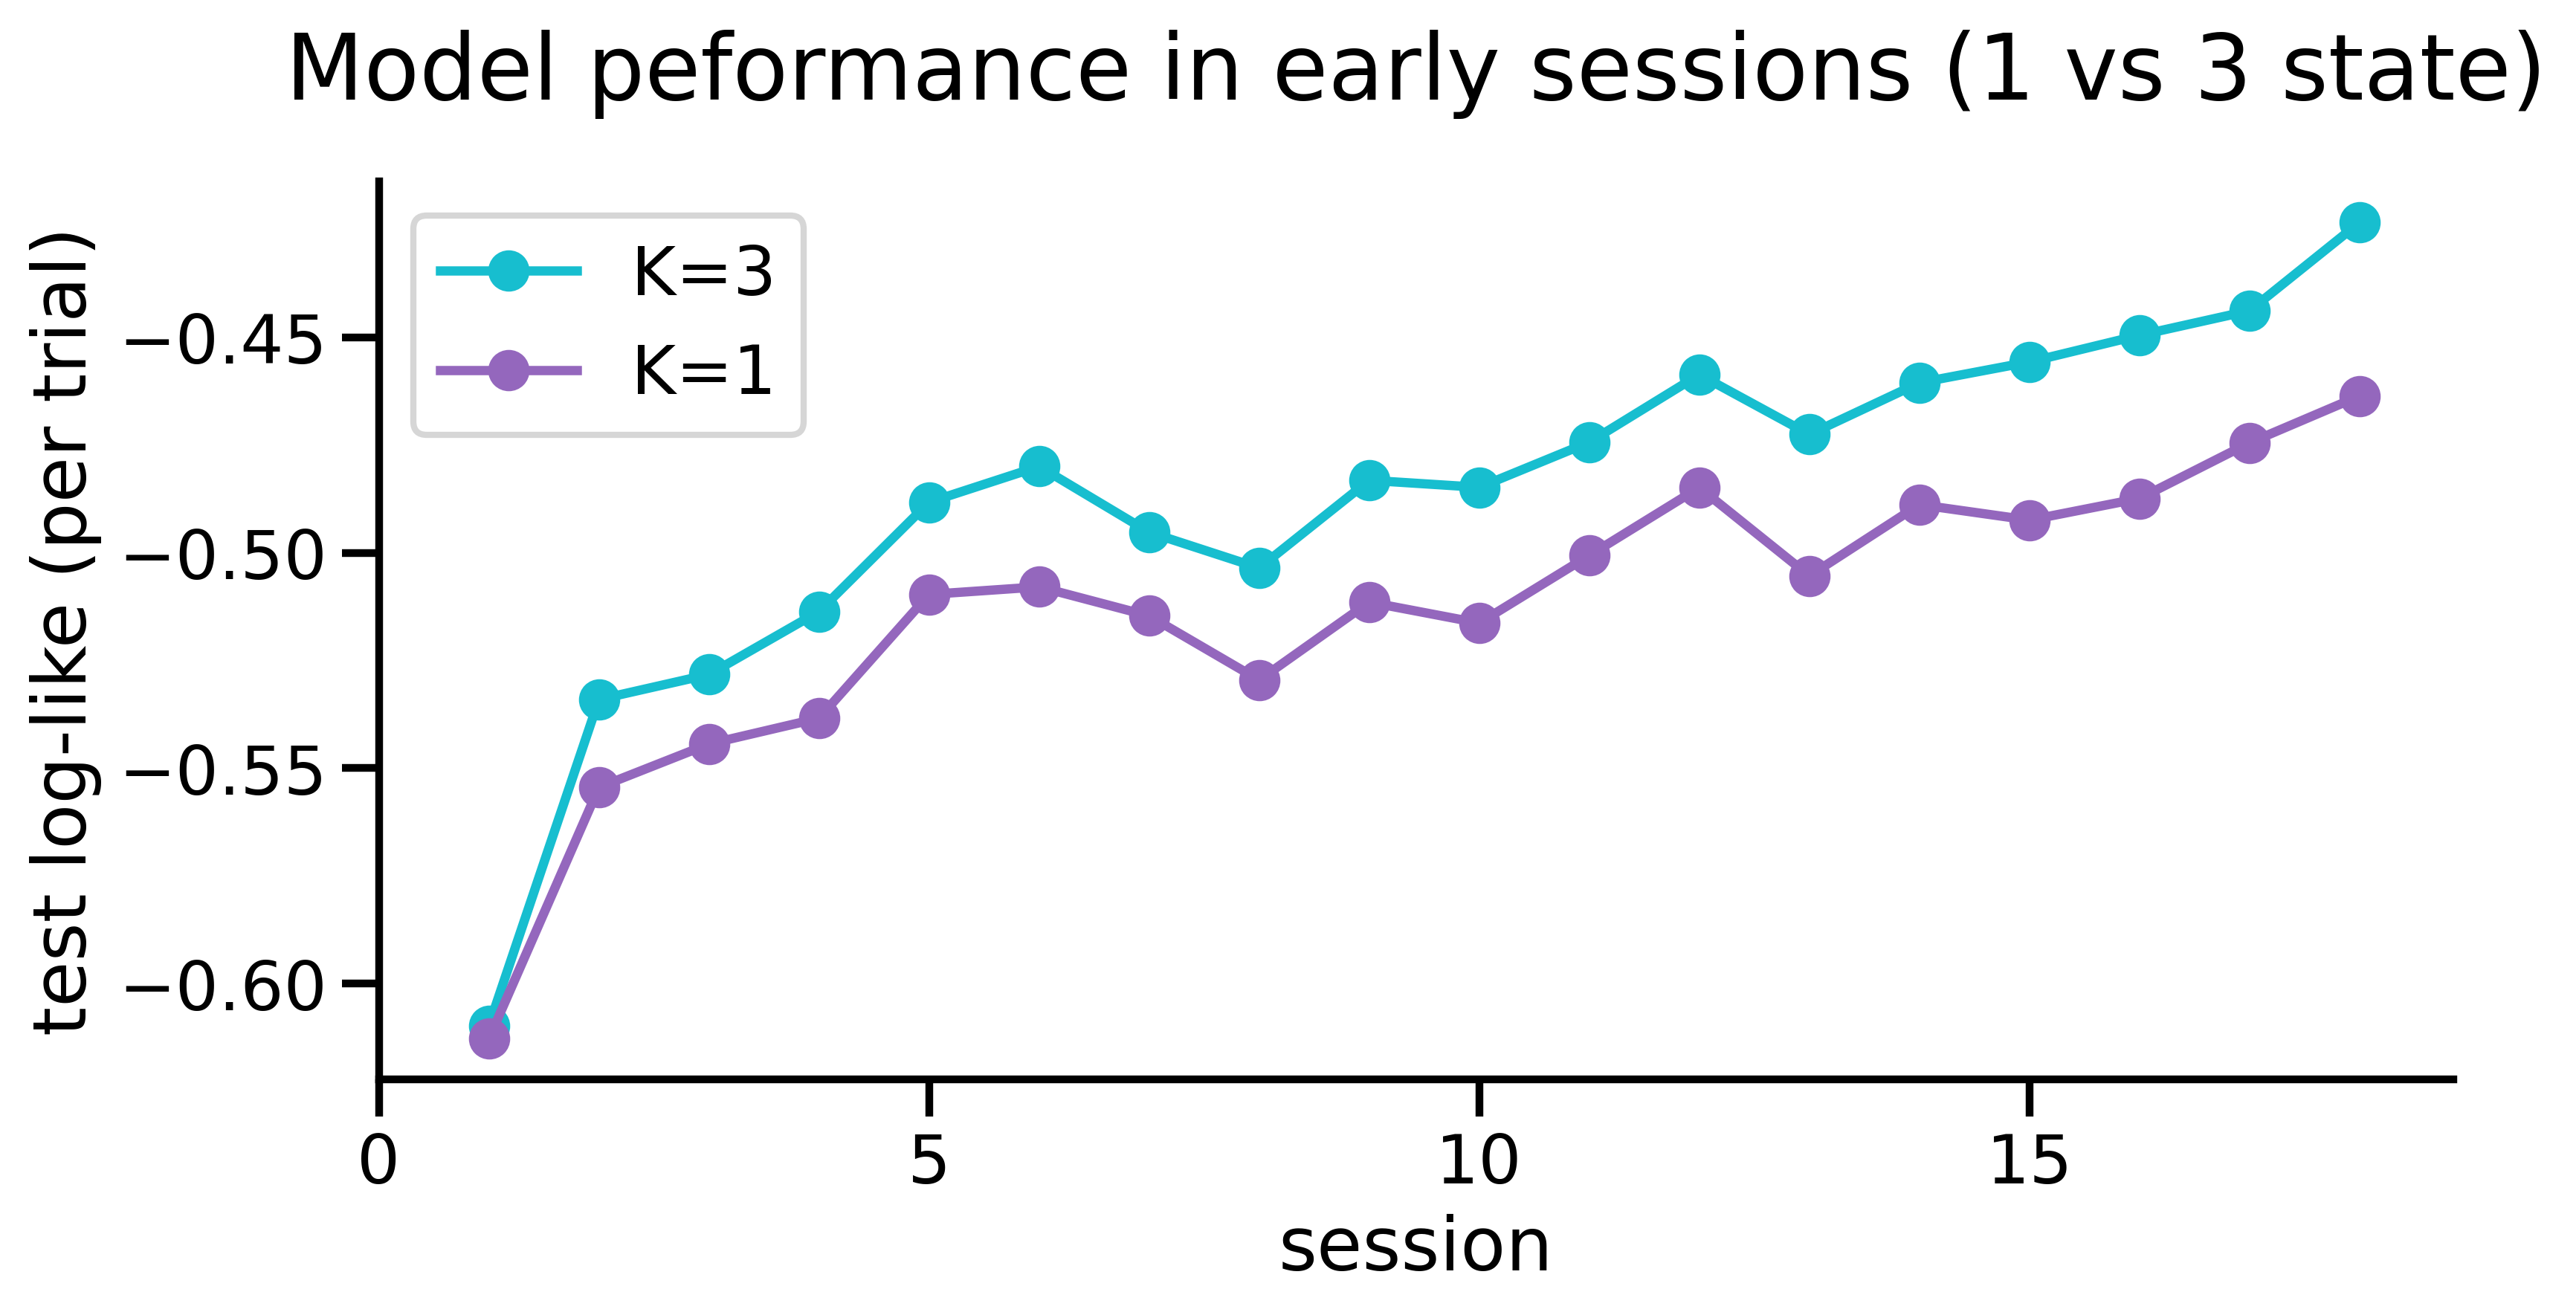

In [65]:
# # setting hyperparameters
# alphaList = [2*(10**x) for x in list(np.arange(-1,6,0.5,dtype=float))] 
# L2penaltyW = 1
# maxiter = 200
# bestSigma = 1 # verified from fitting multiple sigmas
# priorDirP = [100,10] # to read dGLMHMM1 model
# fit_init_states = False
# K = 3
# D = 4 # number of features
# sessStop = -1 # last session to use in fitting
# splitFolds = 5

# bestSigmaInd = 7 # equivalent to sigma=1
# bestAlphaInd = 2 # equivalent to alpha=2

# allW = np.empty((len(subjectsAll), 4), dtype=object)
# allP = np.empty((len(subjectsAll), 4), dtype=object)
# sessInterest = 18

# testLl = np.zeros((len(subjectsAll), 2, sessInterest, splitFolds))

# for idx in range(0, len(subjectsAll)):
#     subject=subjectsAll[idx]
#     x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D) # NOT LOOKING AT FULL DATASET
#     N = x.shape[0]
#     presentTrain, presentTest = split_data(N, sessInd, folds=splitFolds, blocks=10, random_state=1)
    
#     data1 = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_1-state_multiple-sigmas_priorDirP={priorDirP}_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz')
    
#     for fold in range(0, splitFolds):
#         data3 = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_3-state_fold-{fold}_multiple-alphas_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz')
        
#         W_3state = data3['W'][bestAlphaInd]
#         P_3state = data3['P'][bestAlphaInd]
#         pi3 = np.ones((3))/3
#         W_1state = data1['allW'][fold, bestSigmaInd]
#         P_1state = np.ones((N,1,1))
#         pi1 = np.ones((1))

#         dGLM_HMM_3state = dglm_hmm2.dGLM_HMM2(N,3,D,2)
#         testLlSessions = dGLM_HMM_3state.evaluate_per_session(x, y, sessInd, presentTest[fold], P_3state, pi3, W_3state)
#         testLl[idx,1,:,fold] = testLlSessions[0:sessInterest]

#         dGLM_HMM_1state = dglm_hmm2.dGLM_HMM2(N,1,D,2)
#         testLlSessions = dGLM_HMM_1state.evaluate_per_session(x, y, sessInd, presentTest[fold], P_1state, pi1, W_1state)
#         testLl[idx,0,:,fold] = testLlSessions[0:sessInterest]

fig, axes = plt.subplots(1, figsize = (9,4), dpi=400)
avgTestLl = np.mean(testLl, axis=3)
avgTestLl = np.mean(avgTestLl, axis=0)
axes.plot(range(1,sessInterest+1), avgTestLl[1], '-o', color = colormap[2], label='K=3')
axes.plot(range(1,sessInterest+1), avgTestLl[0], '-o', color = colormap[0], label='K=1')
axes.set_xlabel('session')
axes.set_ylabel('test log-like (per trial)')
axes.legend()
axes.set_title('Model peformance in early sessions (1 vs 3 state)', size=22, pad=20)
axes.spines[['right', 'top']].set_visible(False)
axes.set_xticks(range(0,18,5),range(0,18,5))
plt.savefig(f'../figures/Test_Log-Like_1vs3states_early_sessions', bbox_inches='tight', dpi=400)

In [67]:
# Example subject
subject = 'ibl_witten_15'

# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = [100,10]
maxiter = 300
splitFolds = 5
D = 4 # number of features
sessStop = -1 # last session to use in fitting
K = 3
truepi = np.ones((K))/K

x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=4)
biasedBlockTrials, biasedBlockStartInd, biasedBlockSession, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)
N = sessInd[-1]
dGLM_HMM1 = dglm_hmm1.dGLM_HMM1(N,K,D,2)
presentAll = np.ones((N))

# setting hyperparameters
L2penaltyW = 1
maxiter = 200
bestSigma = 1 # verified from fitting multiple sigmas
priorDirP = [100,10]
fit_init_states = False
D = 4 # number of features
sessStop = -1 # last session to use in fitting
bestAlpha = 2 # found by cross-validation
K = 3
inits = 21

In [68]:
_, _, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)
param = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_{K}_state_alpha={bestAlpha}_multiple-initsP_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz')
allP =  param['allP'][0] # starting from best dGLMHMM1 fit
allW =  param['allW'][0] # starting from best dGLMHMM1 fit
 
# Plotting Weights
K = 3
bestSigmaInd = 7
sns.set_context("talk")
myFeatures = [['bias','stimulus', 'previous choice', 'previous reward side'],['bias','contrast left','contrast right', 'previous choice', 'previous reward']]
K = 3
data = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_{K}-state_multiple-sigmas_priorDirP={priorDirP}_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz') 
allP1 = np.mean(data['allP'], axis=0)
allW1 = np.mean(data['allW'], axis=0)    

# computing gamma for bestSigmaInd
dGLM_HMM = dglm_hmm2.dGLM_HMM2(N,K,D,2)
gamma = dGLM_HMM.get_posterior_latent(allP, truepi, allW, x, y, presentAll, sessInd, sortedStateInd=None)
phi = dGLM_HMM.observation_probability(x, allW)
   

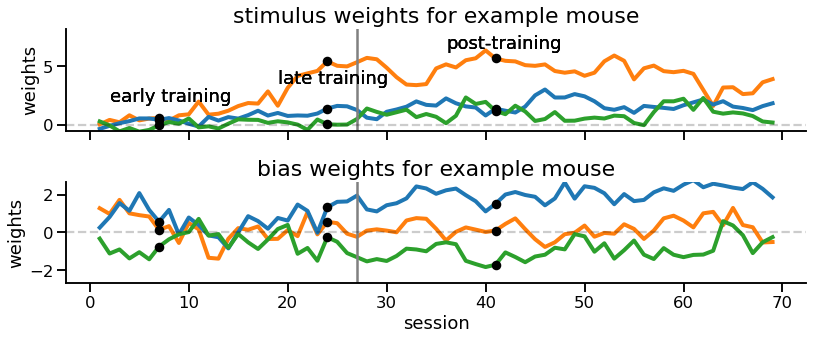

In [149]:
sessionsInterest = [6,23,40] #[56,57,59,60,61,62,66] - beautiful psychometrics # 15 or 16
plotSess = len(sessInd)-1 #min(len(sessInd)-1)#,50)
fig, axes = plt.subplots(2, 1,figsize=(12,5), sharex=True)#, dpi=400)
fig.tight_layout(pad=2)
yLim=[[-2.7,2.7],[-0.5,8.2],[-2.7,2.7],[-2.7,2.7]]
yText = [[2,3.5,6.5,5]]
sessionTitle = ['early training','late training','post-training']
for d in range(0, 2):
    axes[d].axhline(0, alpha=0.2, color='black',linestyle='--')
    for k in range(0, K):
        axes[d].plot(range(1,plotSess+1),-allW[sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=4, alpha=1, label=f'state {k+1}', linestyle='-', zorder=0)
        for s in range(0,len(sessionsInterest)):
            axes[d].scatter(sessionsInterest[s]+1, -allW[sessInd[sessionsInterest[s]],k,1-d,1], color='black', zorder=2, s=65)
            if (d==0):
                axes[d].text(sessionsInterest[s]-4, yText[d][s], sessionTitle[s])
    axes[d].set_ylim(yLim[1-d])
    # axes[d].set_title(f'{myFeatures[D%2][d]}')
    axes[d].set_ylabel(f'weights')
    axes[d].set_title(f'{myFeatures[D%2][1-d]} weights for example mouse', size=22)
    axes[d].spines[['right', 'top']].set_visible(False)
    axes[d].axvline(firstBlockSession+1, color='gray',zorder=0, alpha=1, linewidth=2.5, label='bias blocks introduced')
    # axes[0].legend(loc='upper left', prop={'size': 10})
axes[1].set_xlabel('session')
plt.savefig(f'../figures/weights_fig4_{subject}', bbox_inches='tight', dpi=400)

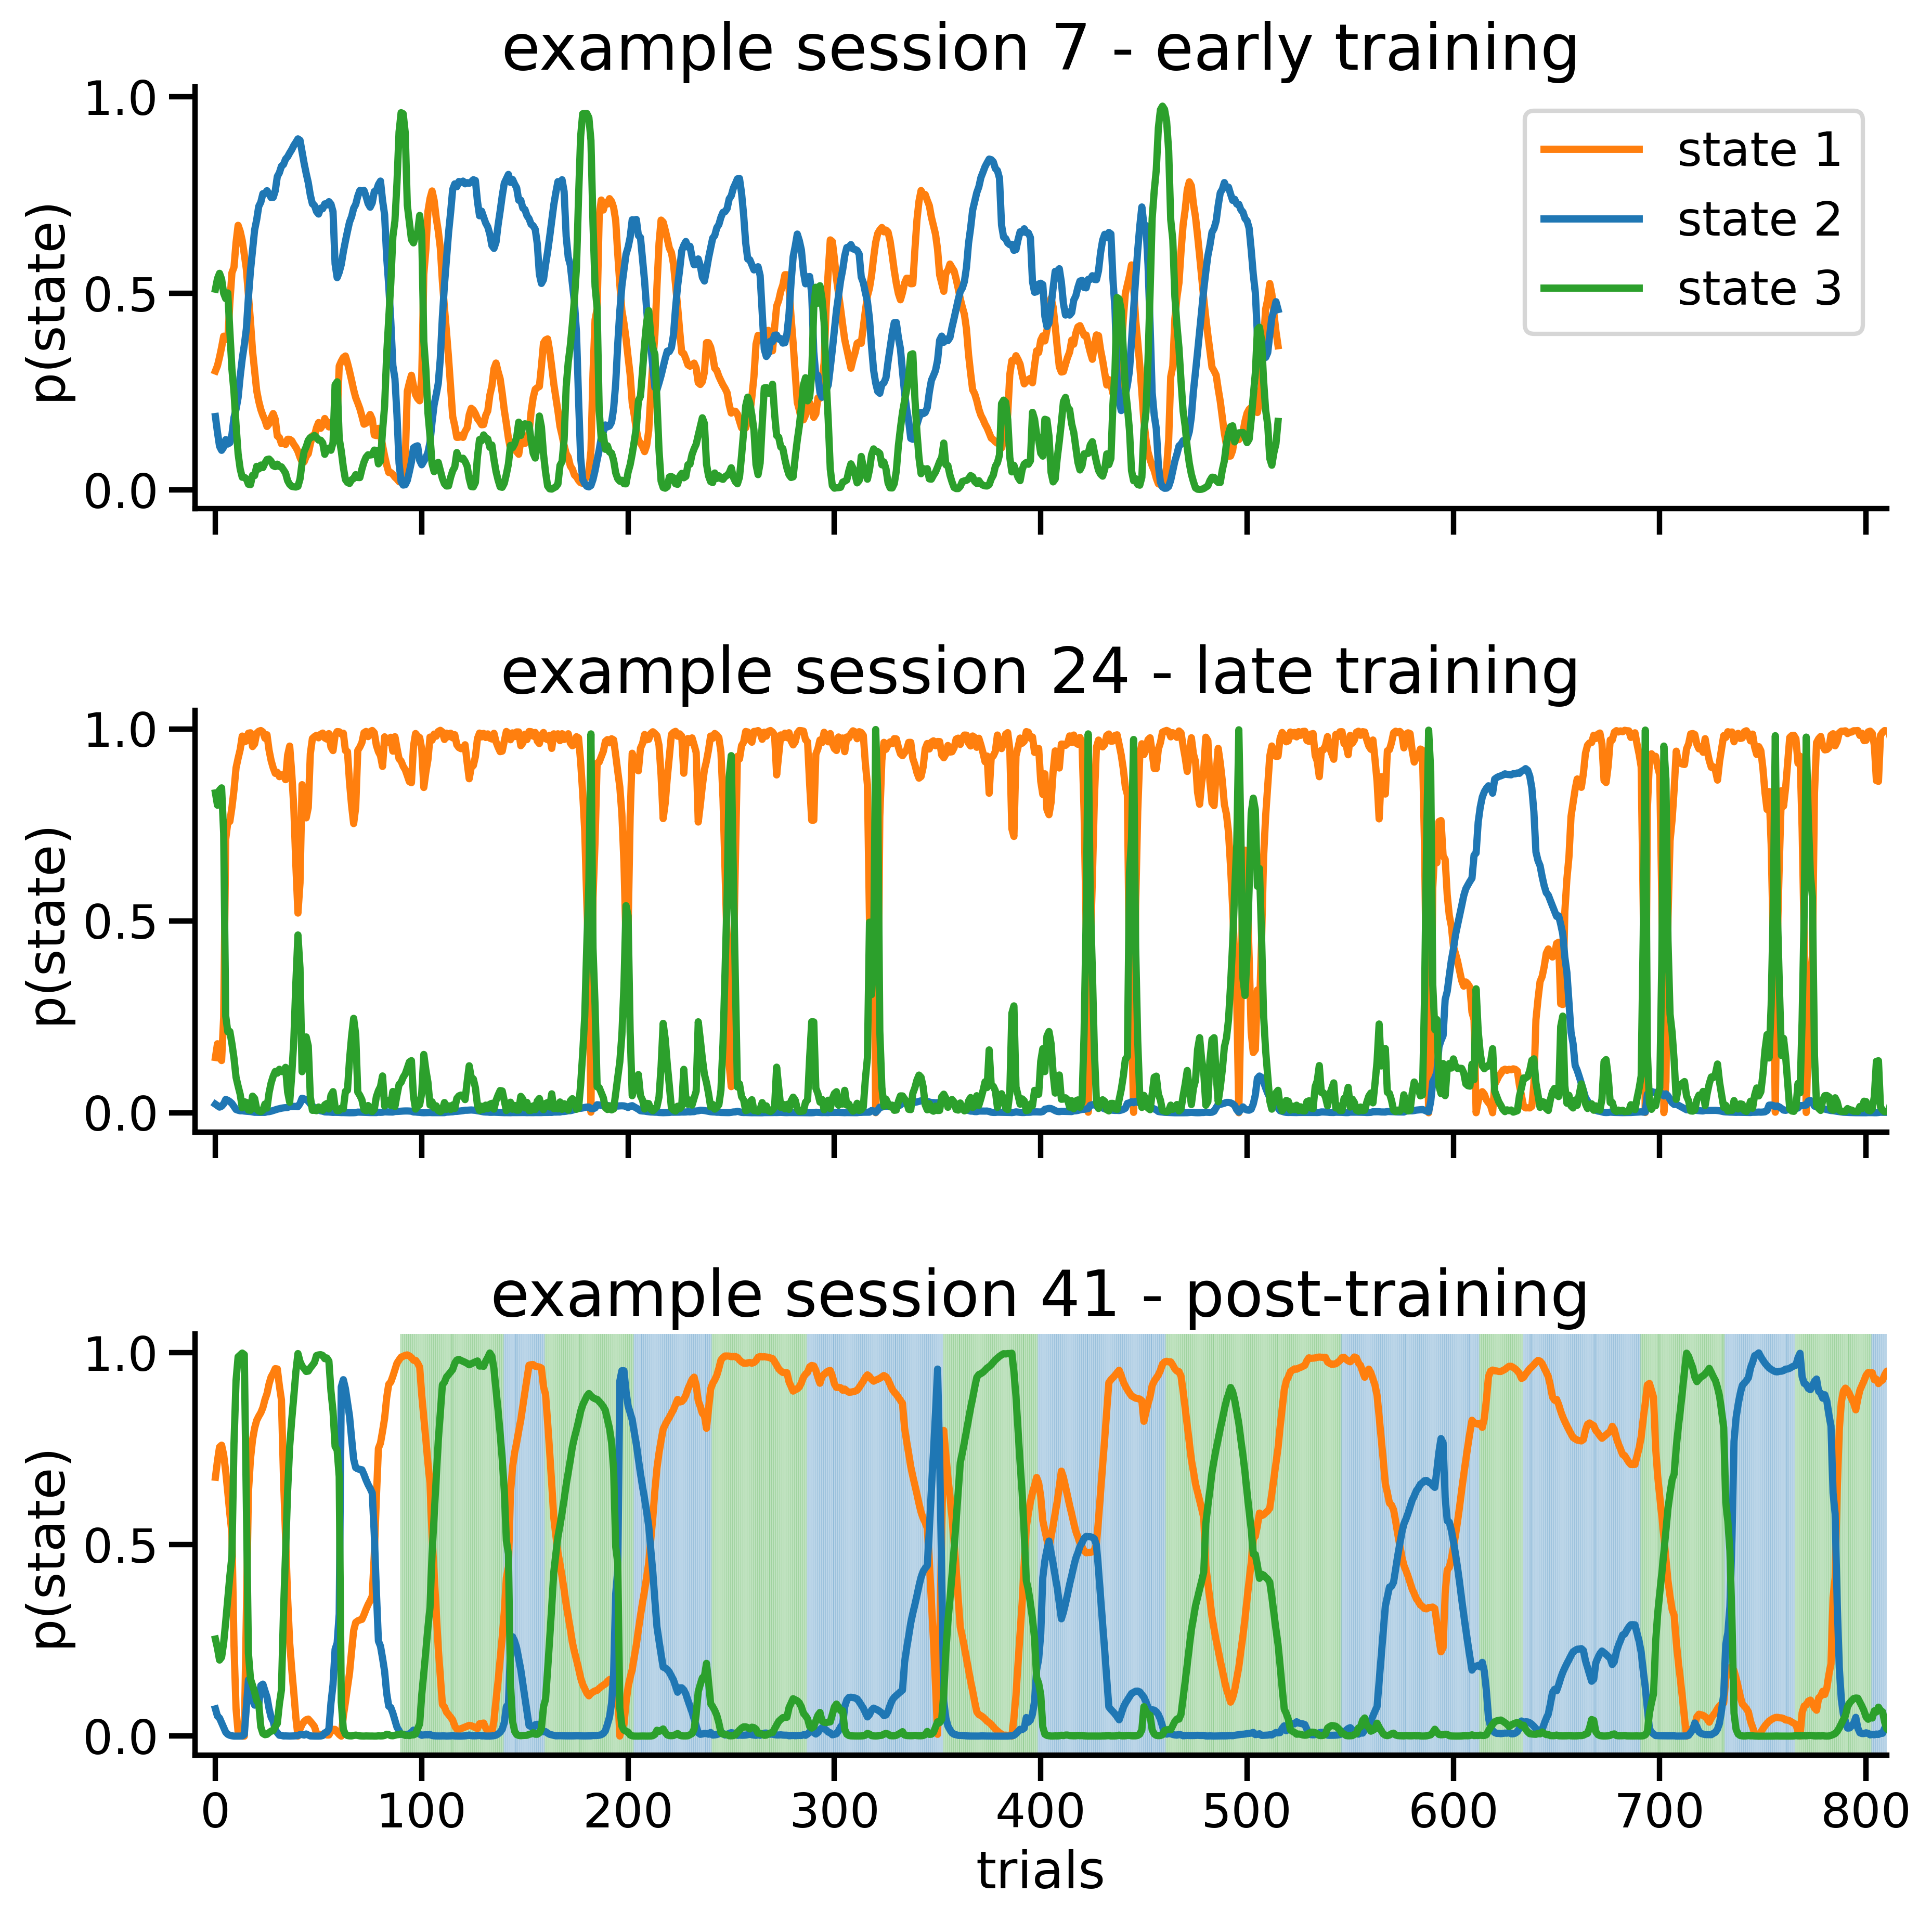

In [173]:
fig, axes = plt.subplots(len(sessionsInterest), 1, figsize=(10.5,10), dpi=400, sharex=True)  # (10.5,9)
fig.tight_layout(pad=3)
plot_posteior_latent(gamma, sessInd, axes, sessions = sessionsInterest, linewidth=2.5)
for s in range(0,len(sessionsInterest)):
    sess = sessionsInterest[s]
    for t in range(sessInd[sess],sessInd[sess+1]):
        if (biasedBlockTrials[t] == 1):
            axes[s].axvline(t-sessInd[sess], color='tab:blue', label='right block', zorder=0, alpha=0.3, linewidth=0.85)
        elif (biasedBlockTrials[t] == -1):
            axes[s].axvline(t-sessInd[sess], color='tab:green', label='left block', zorder=0, alpha=0.3, linewidth=0.85)
    axes[s].set_xlim(-10,810)
    axes[s].set_title(f'example session {sessionsInterest[s]+1} - {sessionTitle[s]}', size=22)
    axes[s].spines[['right', 'top']].set_visible(False)
    if s!= 0:
        axes[s].get_legend().remove()
    axes[s].set_ylabel('p(state)')
    axes[0].legend(loc='upper right')
plt.savefig(f'../figures/posterior_latent_example-sessions_{subject}', bbox_inches='tight', dpi=400)

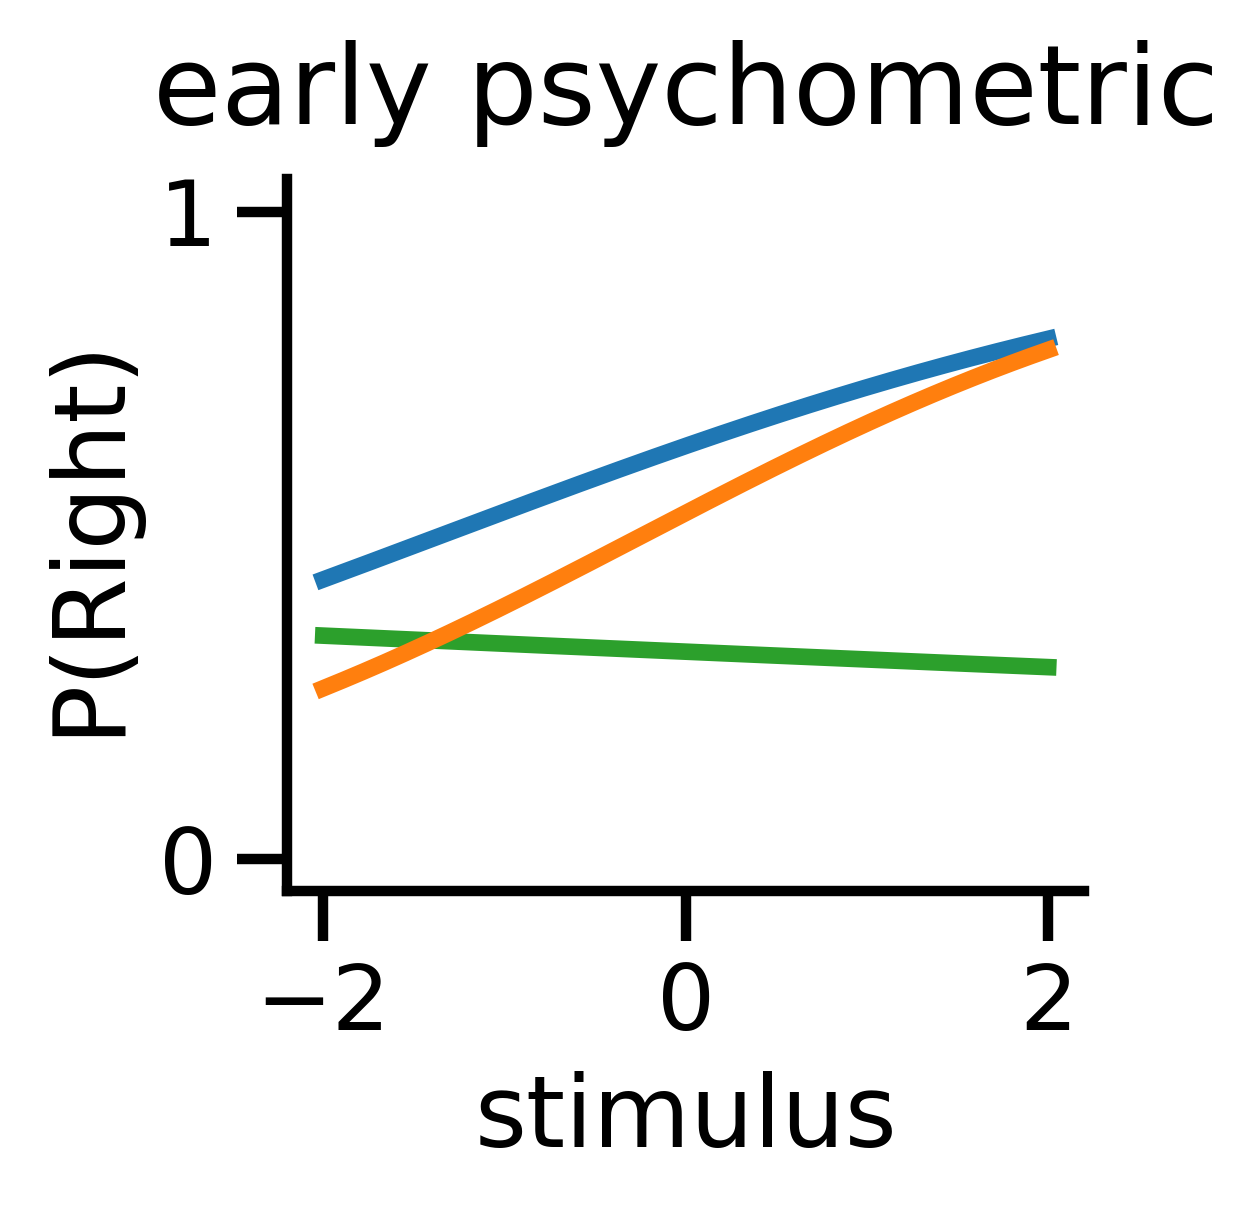

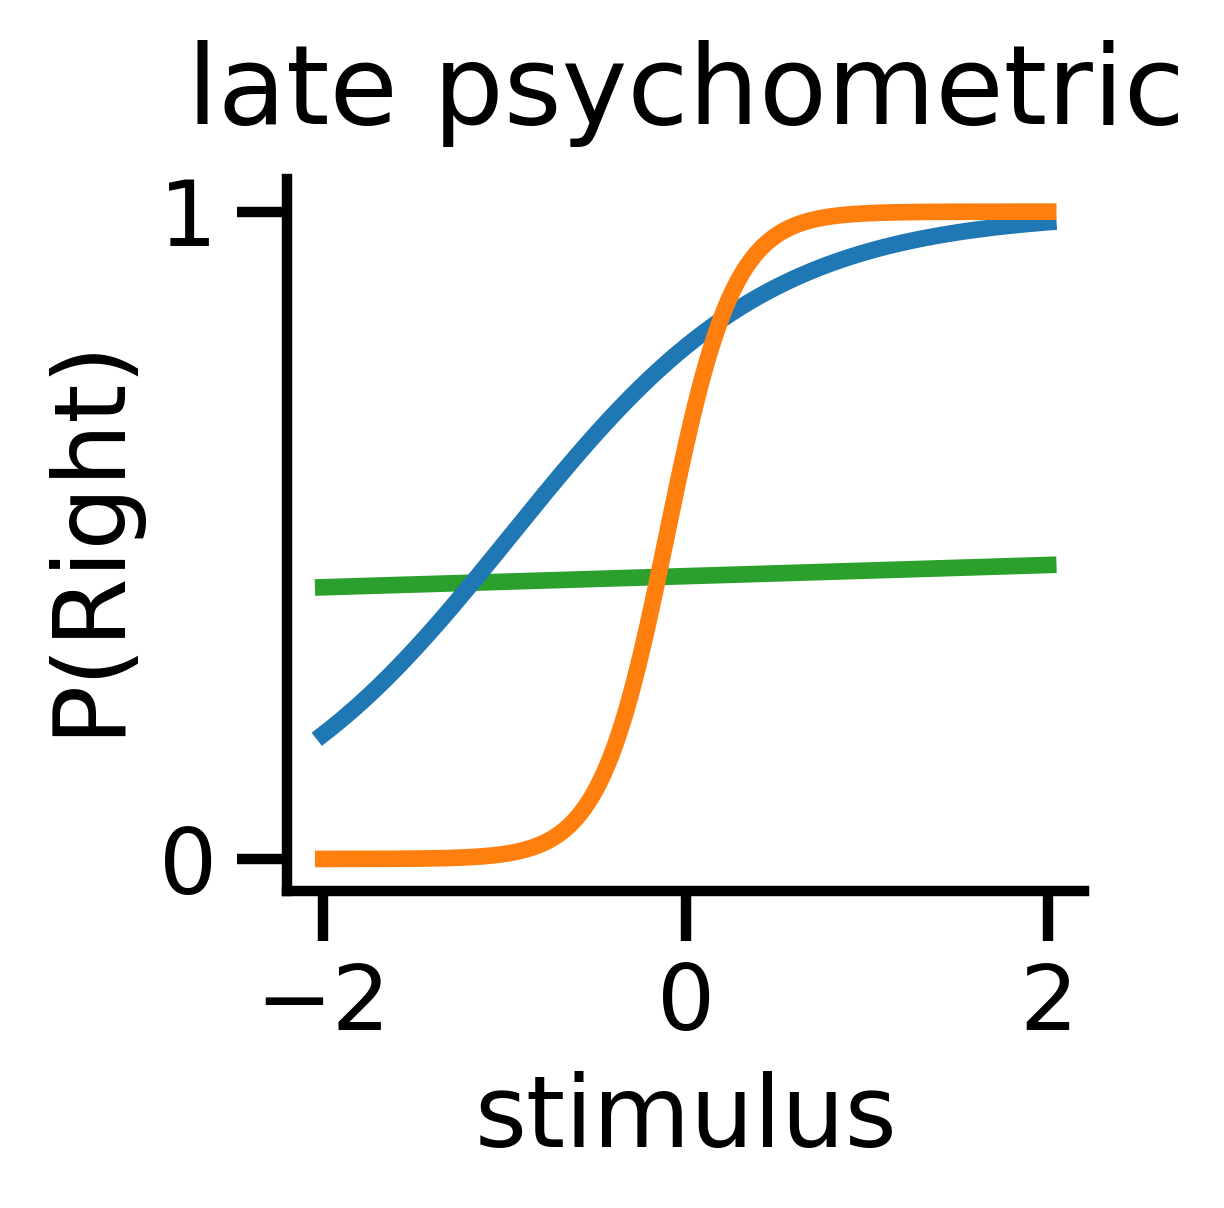

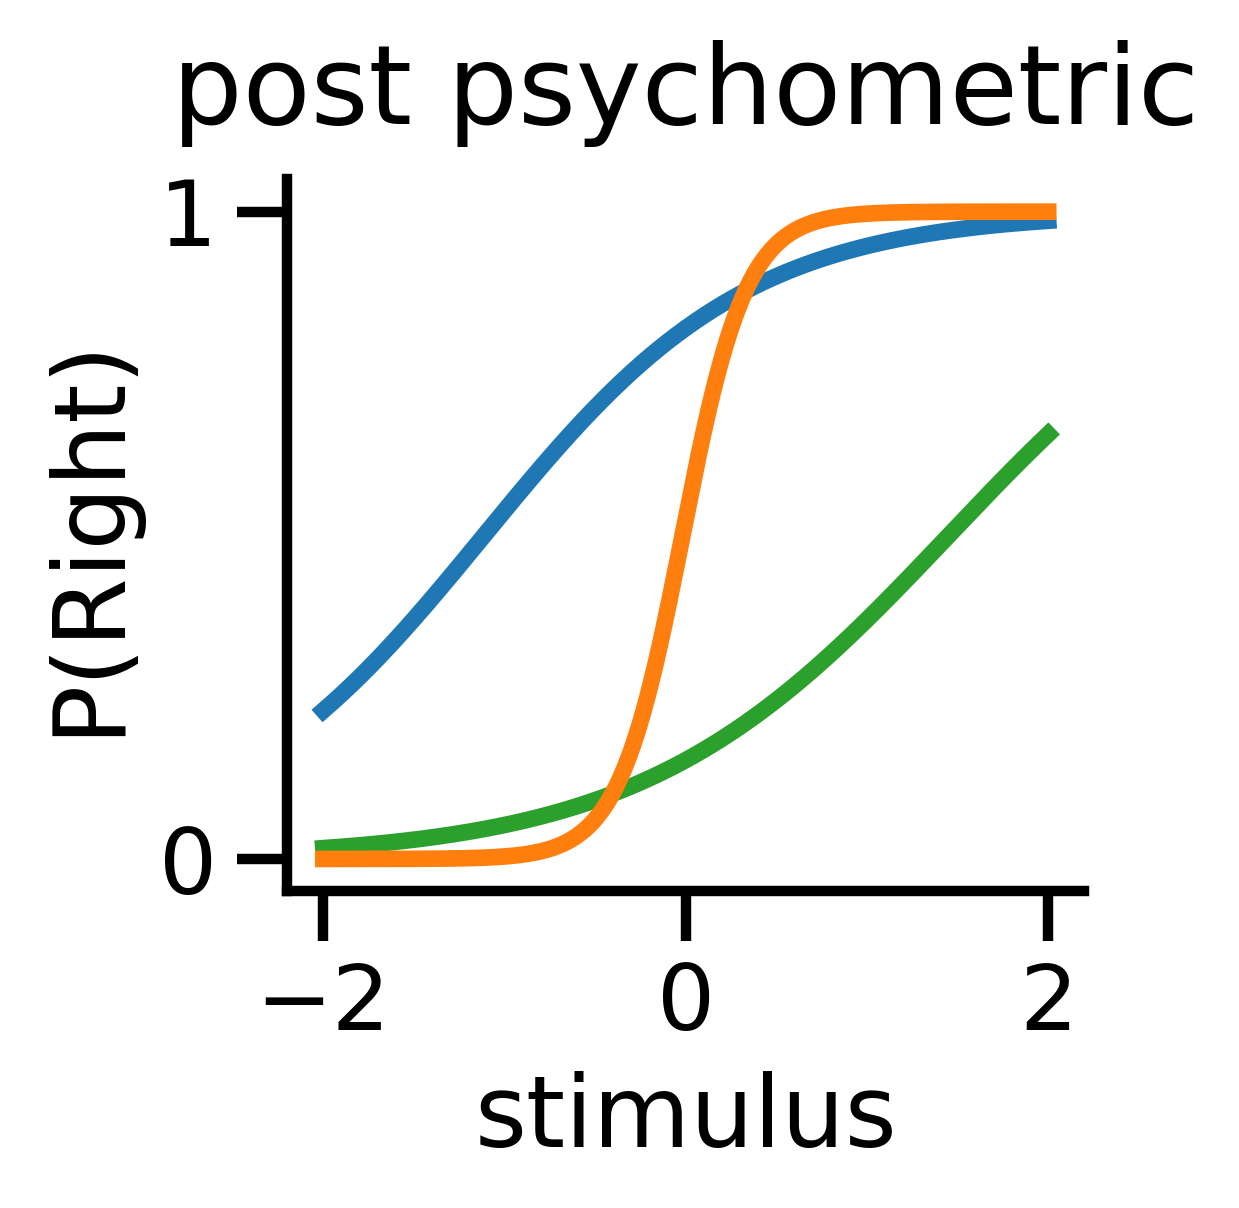

In [170]:
titles = ['early psychometric','late psychometric','post psychometric']
for s in range(0,len(sessionsInterest)):
    fig, axes = plt.subplots(figsize=(3.4,2.8), dpi=400)
    fig.tight_layout()
    plotting_psychometric(w=-allW, sessInd=sessInd, session=sessionsInterest[s], axes=axes, colorsStates=colorsStates)
    axes.set_title(f'{titles[s]}', size=20, pad=10)#(f'example session - {sessionTitle[s]}', size=22)
    axes.spines[['right', 'top']].set_visible(False)
    axes.get_legend().remove()
    axes.set_yticks([0,1],[0,1])
    plt.savefig(f'../figures/psychometric{s}_{subject}', bbox_inches='tight', dpi=400)

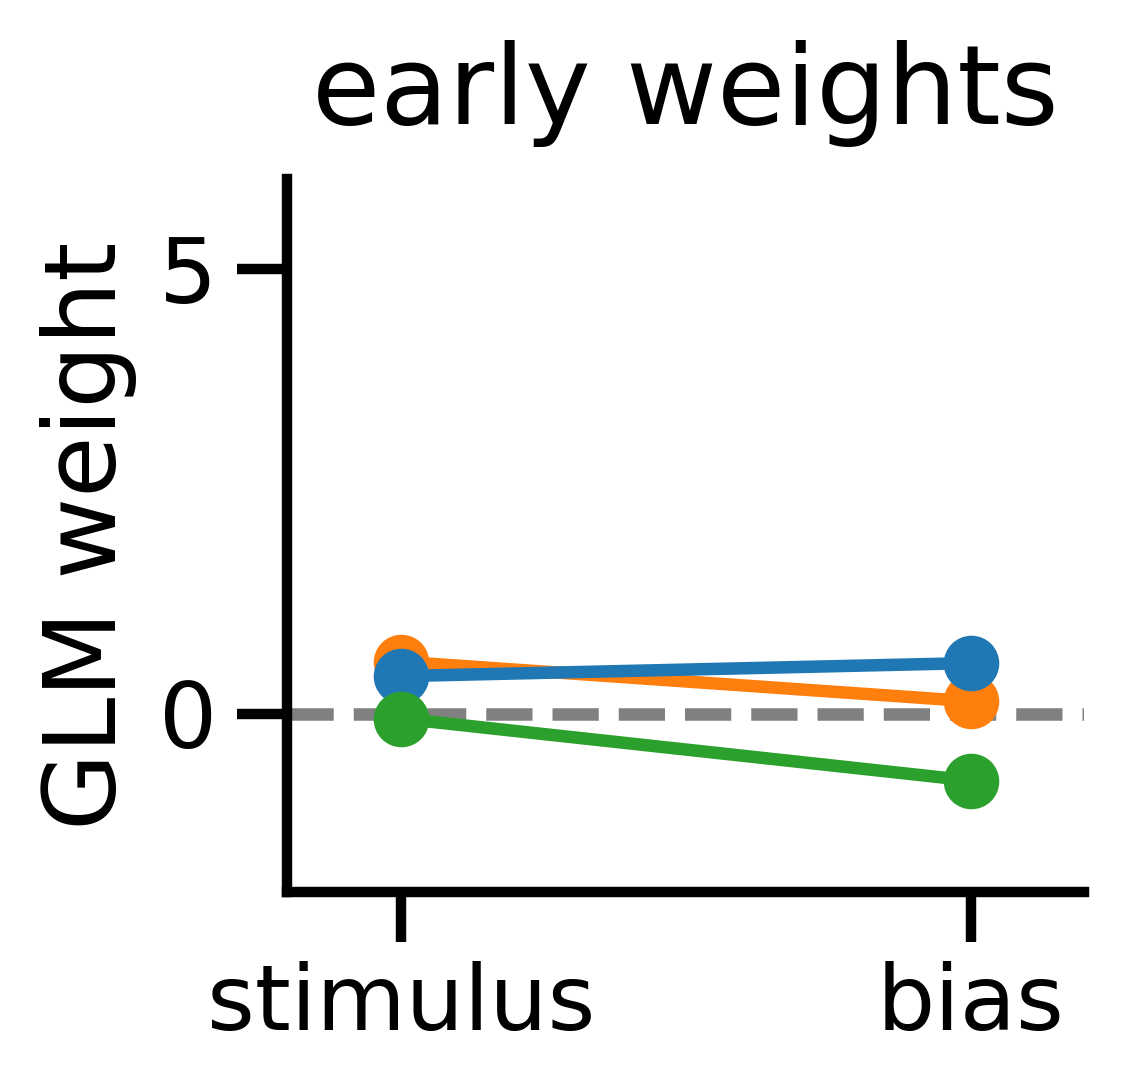

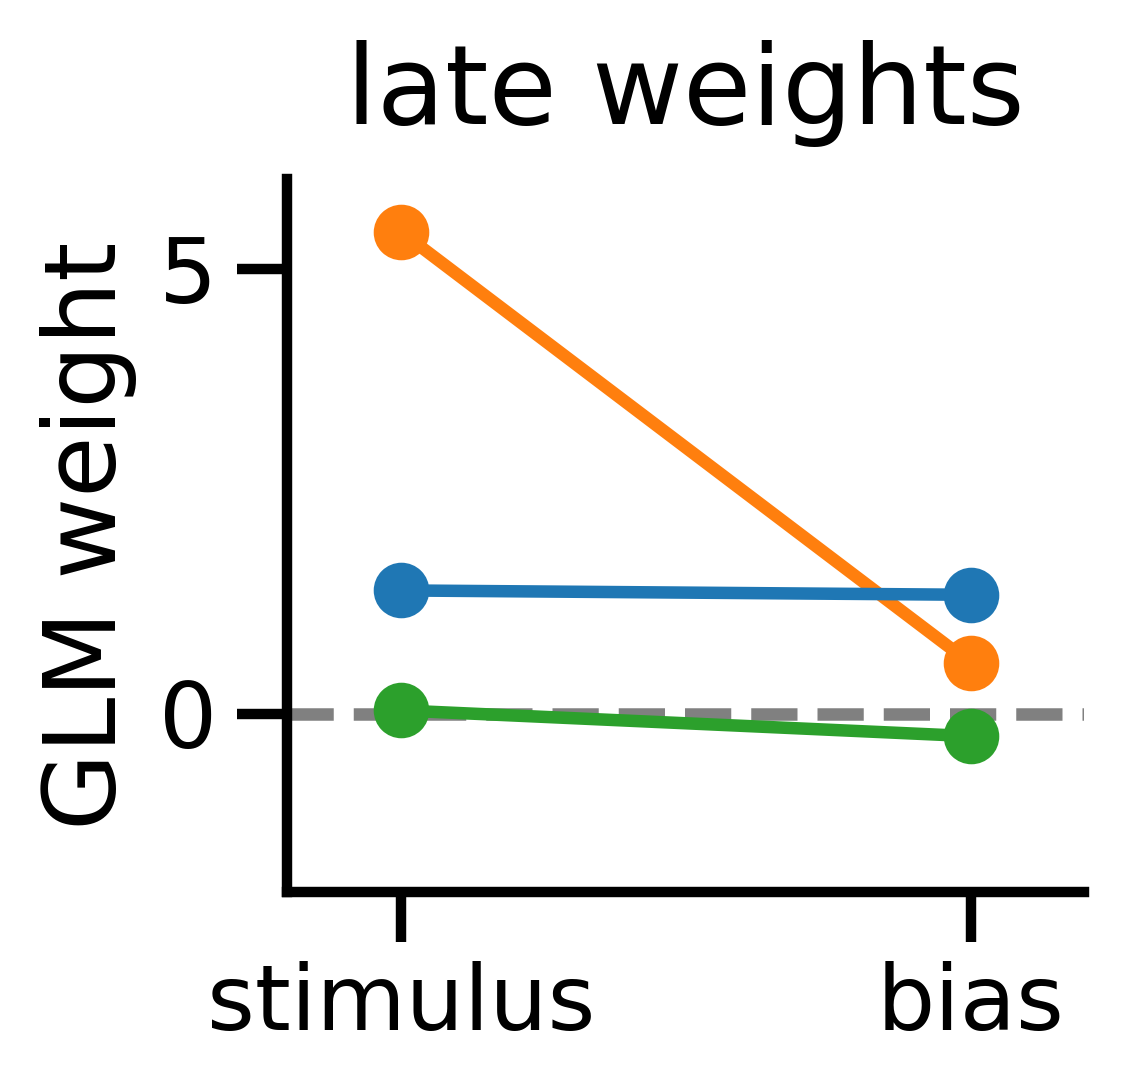

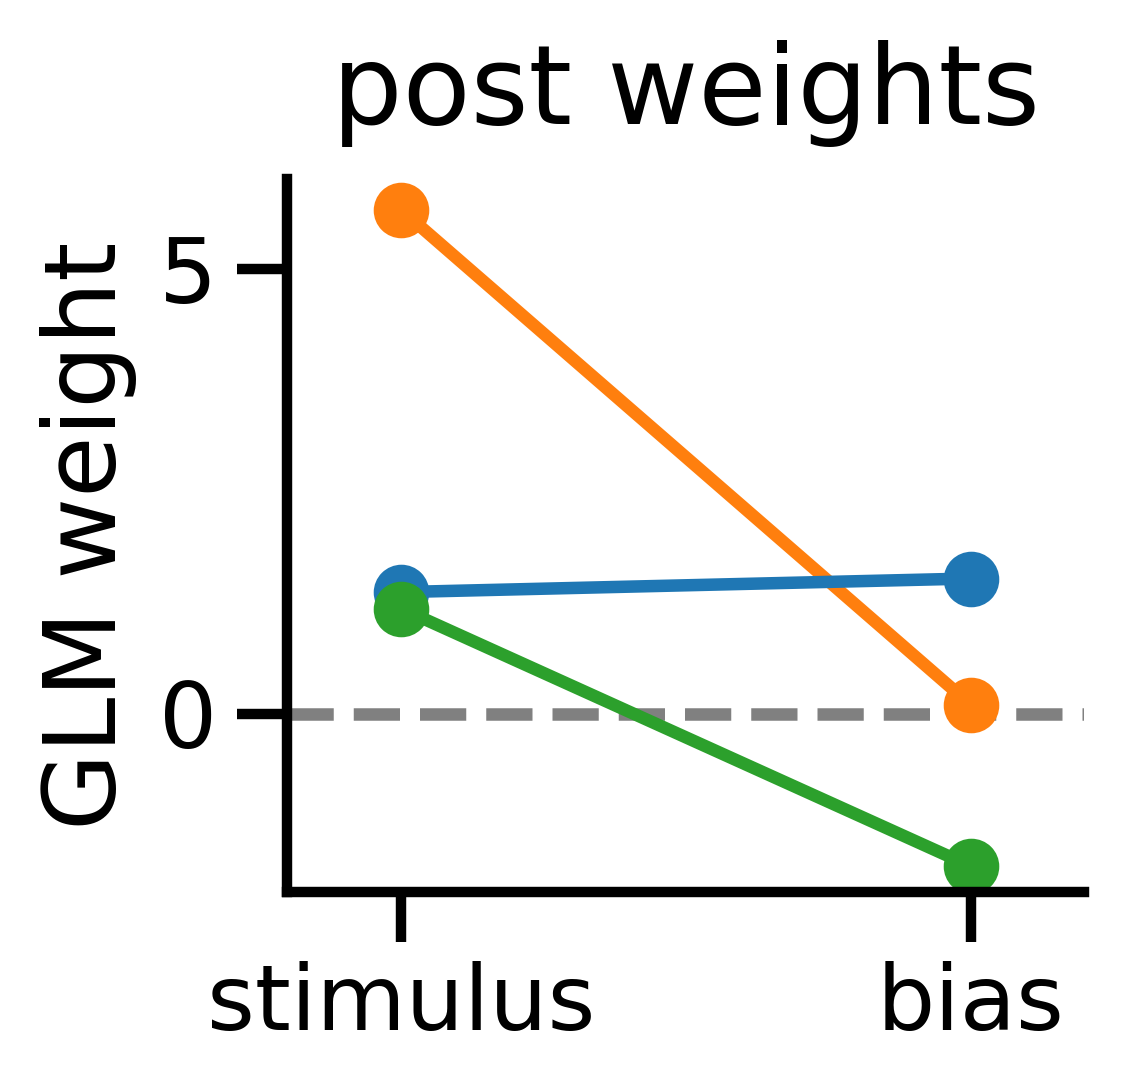

In [169]:
titles = ['early weights','late weights','post weights']
for s in range(0,len(sessionsInterest)):
    fig, axes = plt.subplots(figsize=(3.4,2.8), dpi=400)
    fig.tight_layout()
    axes.axhline(0, color='gray',ls ='dashed')
    for k in range(0,K):
        axes.plot(range(0,2),-allW[sessInd[sessionsInterest[s]],k,[1,0],1], '-o', color=colorsStates[k])
    axes.set_xticks(range(0,2),['stimulus','bias'])
    axes.set_ylabel('GLM weight')
    axes.set_title(f'{titles[s]}', size=20, pad=10)#(f'example session - {sessionTitle[s]}', size=22)
    axes.spines[['right', 'top']].set_visible(False)
    axes.set_xlim(-0.2,1.2)
    axes.set_ylim(-2,6)
    
    plt.savefig(f'../figures/GLM-Weights{s}_{subject}', bbox_inches='tight', dpi=400)